# ML individual models on extracted features

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import os
import gc
from tqdm.notebook import tqdm

## A) Prepare Data Frame for predictors and target variables <br>
Here we want to create two data frames, each for predictors and target feature (loss). While doing this we will use downcasting function which will cast columns of our data frame to appropriate data structures that will help save memory.

In [2]:
# Get target feature i.e., loss from train data set
train=pd.read_csv('inputs/train.csv')
y=train.loss
y=(y+1)**0.25

# Remove train data frame from RAM
del train
gc.collect()

# Load extracted features data sets on test data
te_cat=pd.read_csv('inputs/te_cat.csv')
te_cat=te_cat[te_cat.columns[1:]]
te_num=pd.read_csv('inputs/te_num.csv')
te_num=te_num[te_num.columns[1:]]
test=te_cat.join(te_num)

# Load test ids for kaggle submission
test_id=pd.read_csv('inputs/test.csv')['id']

del te_cat, te_num
gc.collect()

# Load output from feature selection step
sel_feat=pd.read_csv('inputs/Allstate-RFECV-ranking.csv')

# sel_feat has Features and Rank columns. Select only Rank 1 fetures.
cols=sel_feat[sel_feat.Rank==1].Features.tolist()

# Remove sel_feat data frame from RAM
del sel_feat
gc.collect()

# Load features file from feature extraction step (training data set)
X=pd.read_csv('inputs/features.csv')
X=X[cols]

# Keep only selected features in the test data set
test=test[cols]

# Downcast entire data frame to save memory
# credit:https://www.kaggle.com/anshuls235/m5-forecasting-eda-fe-modelling
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

test=downcast(test)
X=downcast(X)
print('Train predictors:',X.shape,'Train target:',y.shape)
print('Test predictors:',test.shape)

Train predictors: (188318, 84) Train target: (188318,)
Test predictors: (125546, 84)


## B) Create helper functions <br>
Note that we will use transformed (scaled+shift) target feature for better prediction results. Since, we are using scaling analysing the models based on the metric score calculated on the scaled target feature may mislead us in the model selection process. Hence, we define a custom metric function which will first unscale and unshift y_prediction, y_true (making values to the original scale) for calculating mean absolute error. <br>
Along with this, we define a funtion which can take in the estimator and parameter list as argument and perform k fold cross validation using sklearn gridserachcv function for optimal hyperparameter search.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import pickle

Using TensorFlow backend.


In [4]:
X_tr,X_cv,y_tr,y_cv=train_test_split(np.array(X),np.array(y),test_size=0.2,random_state=5)

In [34]:
def custom_mae(y_true,y_pred):
    '''Returns mean absolute error of y_pred values in the original scale'''
    y_true=list(map(lambda val:(val**4)-1,y_true))
    y_pred=list(map(lambda val:(val**4)-1,y_pred))
    
    return mae(y_true,y_pred)

custom_metric=make_scorer(custom_mae,greater_is_better=False)

In [35]:
def model_fit(estimator,params,train=X,folds=3,epochs=False):
    '''Uses gridsearch to find best parameter fit for the estimator'''
    
    model=GridSearchCV(estimator=estimator,
                param_grid=params,
                scoring=custom_metric,
                cv=folds,
                return_train_score=True,
                n_jobs=-1)
    model.fit(train,y)
    
    #pickle.dump(model,open('models/model_{0}_{1}.sav'.format(param_n,model.best_params_[param_n]),'wb'))
    
    print('Best params:',model.best_params_,'Best score:',(model.best_score_)*-1,'Mean train score:',-(model.cv_results_['mean_train_score'][model.best_index_]))

    fig,ax=plt.subplots(figsize=(10,7))
    
    ax.plot(range(len(model.cv_results_['params'])),list(map(lambda val:val*-1,model.cv_results_['mean_train_score'])), label='Train error')
    ax.scatter(range(len(model.cv_results_['params'])),list(map(lambda val:val*-1,model.cv_results_['mean_train_score'])))
    ax.plot(range(len(model.cv_results_['params'])),list(map(lambda val:val*-1,model.cv_results_['mean_test_score'])), label='Hold out')
    ax.scatter(range(len(model.cv_results_['params'])),list(map(lambda val:val*-1,model.cv_results_['mean_test_score'])))
    
    ax.set_xticks(range(len(model.cv_results_['params'])))
    ax.set_xticklabels(model.cv_results_['params'], rotation=45)
    ax.set_title('Mean errors plot')
    ax.set_xlabel('Parameter values')
    ax.set_ylabel('Mean of MAE erros')
    ax.legend()

In [7]:
def kaggle_submission(pred,filename):
    y_pred=list(map(lambda val:(val**4)-1,pred))
    my_sub=pd.DataFrame({'id':test_id,'loss':y_pred})
    my_sub.to_csv(filename,index=False)
    
    print('File saved')

In [13]:
if not os.path.exists('submissions/third/'):
    os.makedirs('submissions/third/')

## C) ML Models <br>
Here, we will use 8 different models to predict target values. We will also tune hyperparameters of each of the models to compare their best performances.
## 1. Random Guessing

In [9]:
y_cv_pred_nor=np.random.normal(y_tr.mean(),y_tr.std(),y_cv.shape[0])
y_cv_pred_nor=np.array(list(map(lambda val:(val**4)-1, y_cv_pred_nor)))
print('MAE on cv (normal):',mae(y_cv,y_cv_pred_nor))

MAE on cv (normal): 2976.3263929180334


In [14]:
y_pred=np.random.normal(y.mean(),y.std(),test.shape[0])
kaggle_submission(y_pred,'submissions/third/normal_guessing_submission.csv')

File saved


#### Kaggle submission
<img src='submissions/third/normal_guessing_submission.png'>

## 2. Ridge regression

Best params: {'alpha': 0.001} Best score: 1245.3841384945677 Mean train score: 1244.68783260589


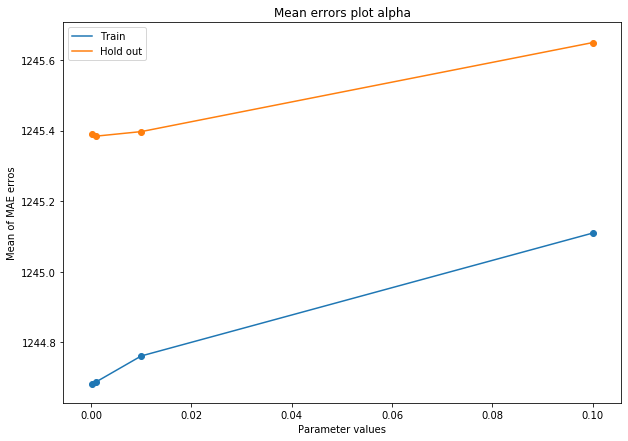

In [18]:
est=Ridge(random_state=16)
params={'alpha':[0.0001,0.001,0.01,0.1]}
model_fit(estimator=est,params=params,folds=5)

Best params: {'alpha': 0.003} Best score: 1245.3810268831253 Mean train score: 1244.704846718195


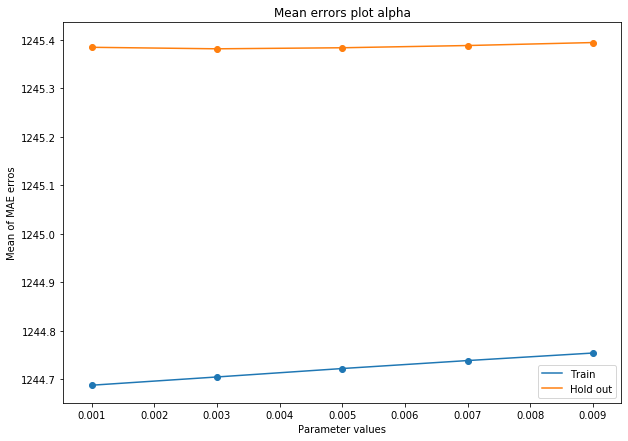

In [19]:
est=Ridge(random_state=16)
params={'alpha':[i/1000 for i in range(1,10,2)]}
model_fit(estimator=est,params=params,folds=5)

Best params: {'alpha': 0.003} Best score: 1245.3810268831253 Mean train score: 1244.704846718195


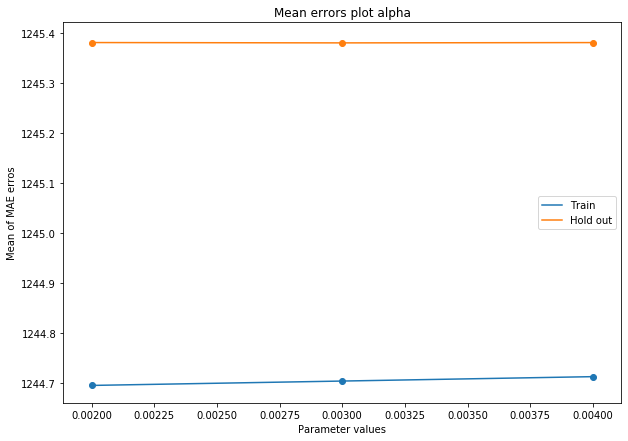

In [23]:
est=Ridge(random_state=16)
params={'alpha':[0.002,0.003,0.004]}
model_fit(estimator=est,params=params,folds=5)

In [20]:
reg=Ridge(alpha=0.003)
reg.fit(np.array(X),np.array(y))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,'submissions/third/ridge_submission.csv')

File saved


#### Kaggle submission
<img src='submissions/third/ridge_submission.png'>

## 3. Stochastic gradient descent (SGD) with Squared loss error <br>
### 3.1 learning rate

Best params: {'eta0': 0.0001} Best score: 1350.963283925687 Mean train score: 1349.1389376571265


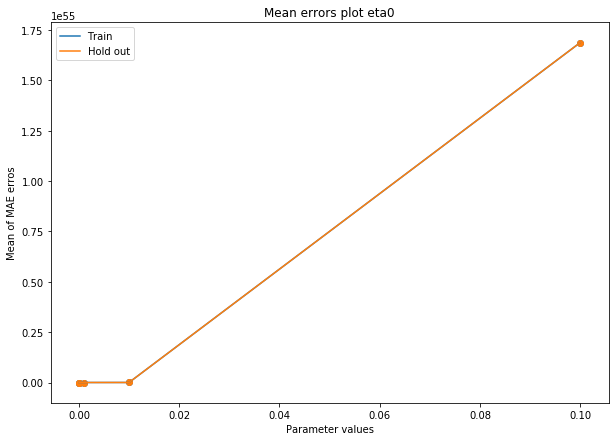

In [21]:
est=SGDRegressor(loss='squared_loss',
                early_stopping=True,
                random_state=16)
params={'eta0':[0.00001,0.0001,0.001,0.01,0.1]}

model_fit(estimator=est,params=params,folds=5)

Best params: {'eta0': 0.0001} Best score: 1350.963283925687 Mean train score: 1349.1389376571265


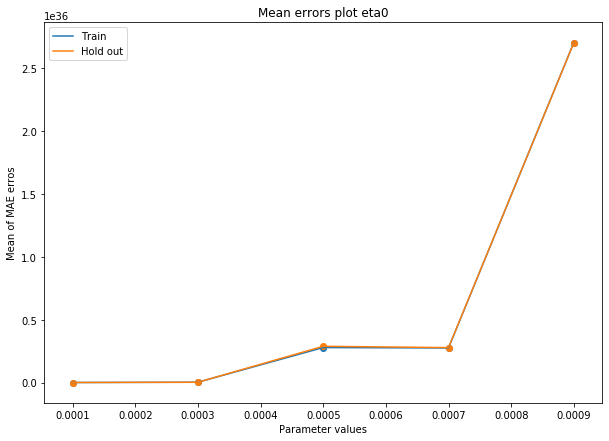

In [22]:
est=SGDRegressor(loss='squared_loss',
                early_stopping=True,
                random_state=16)
params={'eta0':[i/10000 for i in range(1,10,2)]}

model_fit(estimator=est,params=params,folds=5)

Best params: {'eta0': 0.0001} Best score: 1350.963283925687 Mean train score: 1349.1389376571265


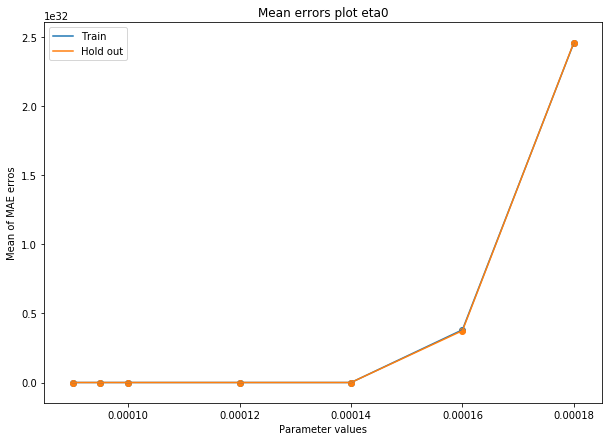

In [24]:
est=SGDRegressor(loss='squared_loss',
                early_stopping=True,
                random_state=16)
params={'eta0':[0.00009,0.000095]+[i/100000 for i in range(10,20,2)]}

model_fit(estimator=est,params=params,folds=5)

### 3.2 l1 ratio

Best params: {'l1_ratio': 0.0} Best score: 1350.963283925687 Mean train score: 1349.1389376571265


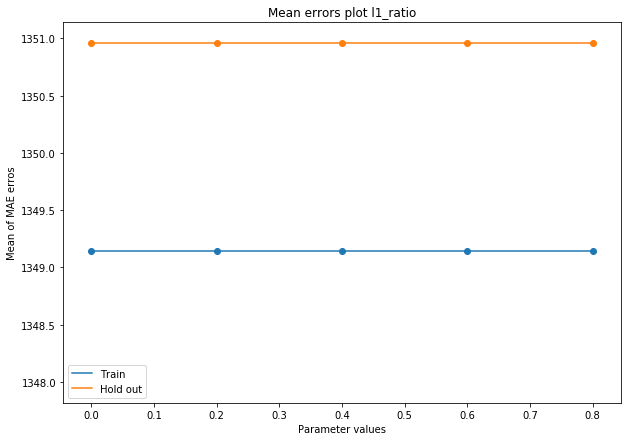

In [26]:
est=SGDRegressor(loss='squared_loss',
                eta0=0.0001,
                early_stopping=True,
                random_state=16)
params={'l1_ratio':[i/10 for i in range(0,10,2)]}

model_fit(estimator=est,params=params,folds=5)

In [27]:
reg=SGDRegressor(loss='squared_loss',
                eta0=0.0001,
                l1_ratio=0,
                early_stopping=True,
                random_state=16)
reg.fit(np.array(X),np.array(y))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,'submissions/third/SGD_sq_submission.csv')

File saved


#### Kaggle submission
<img src='submissions/third/SGD_sq_submission.png'>

## 4 SVR (Support Vector Regressor) with SGD <br>
### 4.1 learning rate

Best params: {'eta0': 0.0001} Best score: 1374.3551306796467 Mean train score: 1374.7775990566824


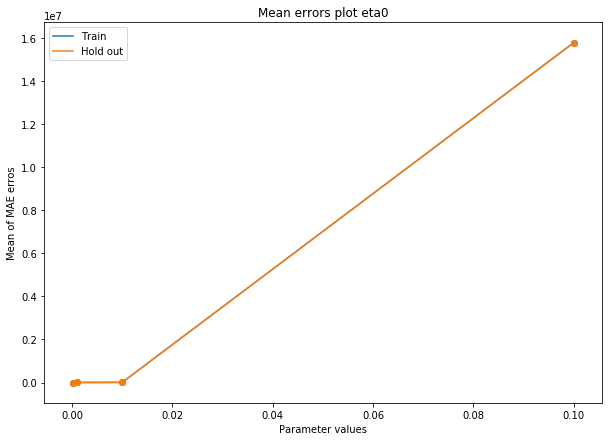

In [28]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0001,
                early_stopping=True,
                random_state=16)
params={'eta0':[0.0001,0.001,0.01,0.1]}

model_fit(estimator=est,params=params,folds=5)

Best params: {'eta0': 0.0003} Best score: 1332.566694041602 Mean train score: 1330.915988137514


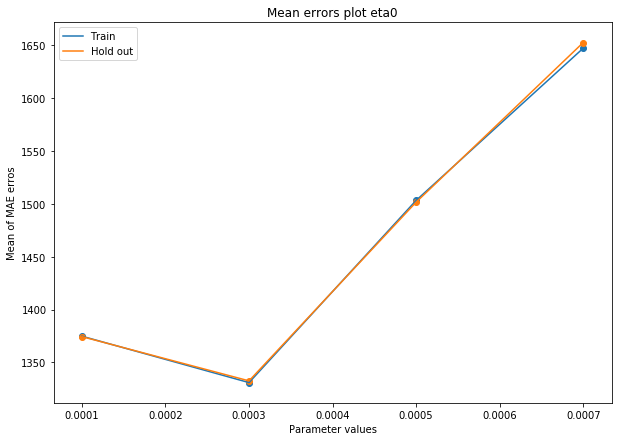

In [29]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0001,
                early_stopping=True,
                random_state=16)
params={'eta0':[i/10000 for i in range(1,9,2)]}

model_fit(estimator=est,params=params,folds=5)

Best params: {'eta0': 0.0002} Best score: 1319.5400814835593 Mean train score: 1319.1792804338495


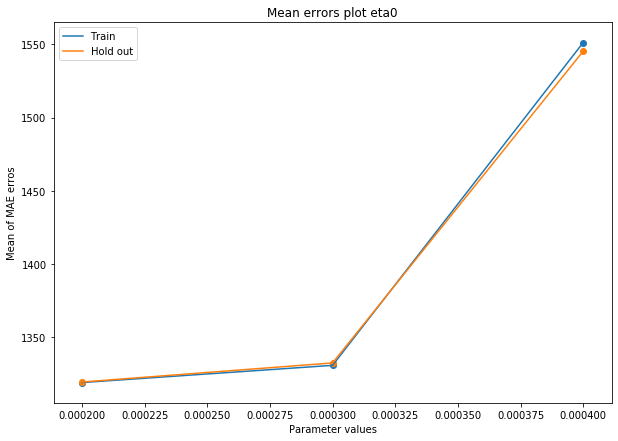

In [30]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0001,
                early_stopping=True,
                random_state=16)
params={'eta0':[0.0002,0.0003,0.0004]}

model_fit(estimator=est,params=params,folds=5)

### 4.2 epsilon

Best params: {'epsilon': 0.1} Best score: 1319.5400814835593 Mean train score: 1319.1792804338495


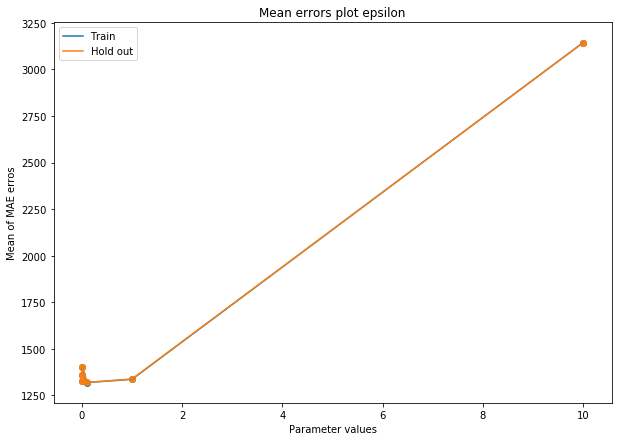

In [31]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0002,
                early_stopping=True,
                random_state=16)
params={'epsilon':[0.0001,0.001,0.01,0.1,1,10]}

model_fit(estimator=est,params=params,folds=5)

Best params: {'epsilon': 0.1} Best score: 1319.5400814835593 Mean train score: 1319.1792804338495


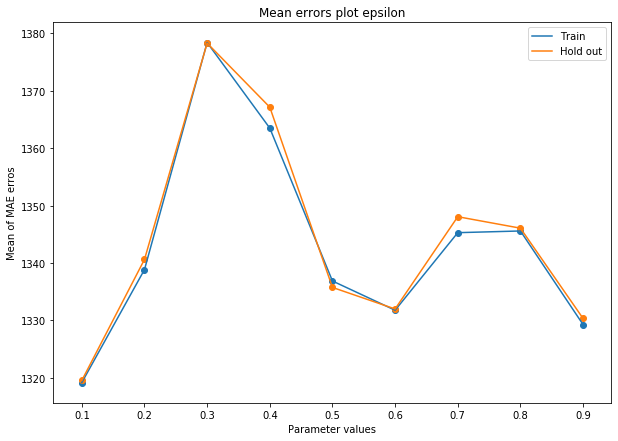

In [32]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0002,
                early_stopping=True,
                random_state=16)
params={'epsilon':[i/100 for i in range(10,100,10)]}

model_fit(estimator=est,params=params,folds=5)

### 4.3 l1 ratio

Best params: {'l1_ratio': 0.0} Best score: 1319.5400814835593 Mean train score: 1319.1792804338495


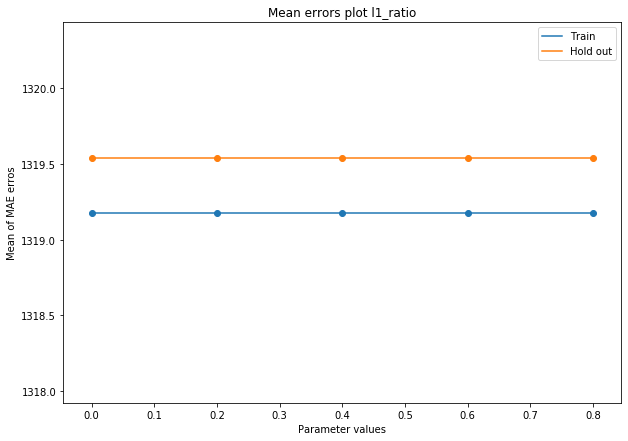

In [33]:
est=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0002,
                epsilon=0.1,
                early_stopping=True,
                random_state=16)
params={'l1_ratio':[i/10 for i in range(0,10,2)]}

model_fit(estimator=est,params=params,folds=5)

In [35]:
reg=SGDRegressor(loss='epsilon_insensitive',
                eta0=0.0002,
                epsilon=0.1,
                l1_ratio=0,
                early_stopping=True,
                random_state=16)
reg.fit(np.array(X),np.array(y))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,'submissions/third/SGD_svr_submission.csv')

File saved


#### Kaggle submission
<img src='submissions/third/SGD_svr_submission.png'>

## 5. SGD with huber <br>
### 5.1 learning rate

Best params: {'eta0': 0.001} Best score: 1381.1660597248165 Mean train score: 1383.295551565041


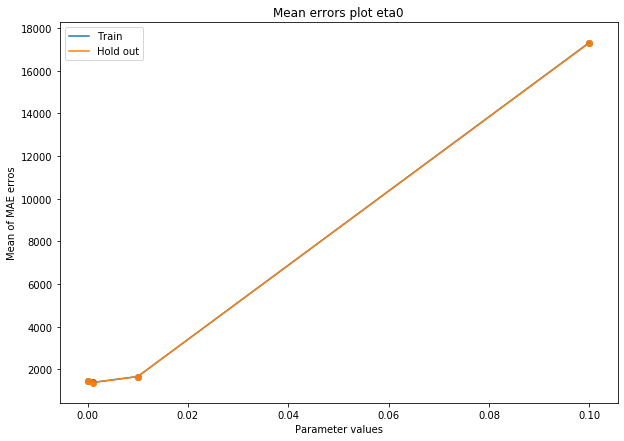

In [36]:
est=SGDRegressor(loss='huber',
                early_stopping=True,
                random_state=16)
params={'eta0':[0.0001,0.001,0.01,0.1]}

model_fit(estimator=est,params=params,folds=5)

Best params: {'eta0': 0.001} Best score: 1381.1660597248165 Mean train score: 1383.295551565041


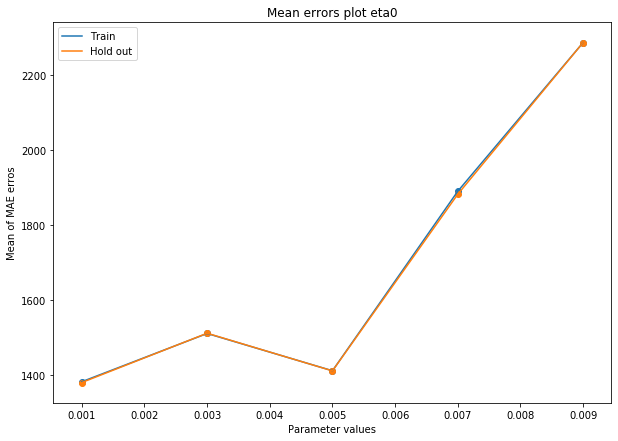

In [37]:
est=SGDRegressor(loss='huber',
                early_stopping=True,
                random_state=16)
params={'eta0':[i/1000 for i in range(1,10,2)]}

model_fit(estimator=est,params=params,folds=5)

### 5.2 epsilon

Best params: {'epsilon': 0.1} Best score: 1381.1660597248165 Mean train score: 1383.295551565041


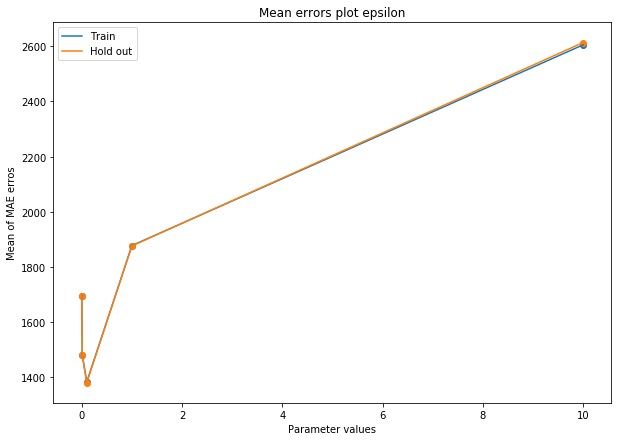

In [40]:
est=SGDRegressor(loss='huber',
                 eta0=0.001,
                early_stopping=True,
                random_state=16)
params={'epsilon':[0.001,0.01,0.1,1,10]}

model_fit(estimator=est,params=params,folds=5)

Best params: {'epsilon': 0.3} Best score: 1318.9378221645588 Mean train score: 1320.5401044955795


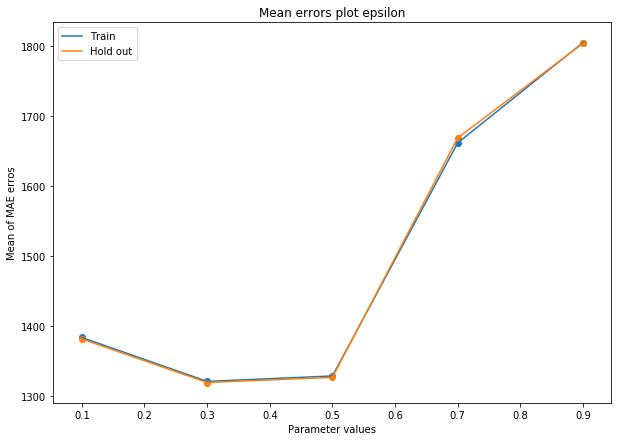

In [41]:
est=SGDRegressor(loss='huber',
                 eta0=0.001,
                early_stopping=True,
                random_state=16)
params={'epsilon':[i/10 for i in range(1,10,2)]}

model_fit(estimator=est,params=params,folds=5)

Best params: {'epsilon': 0.3} Best score: 1318.9378221645588 Mean train score: 1320.5401044955795


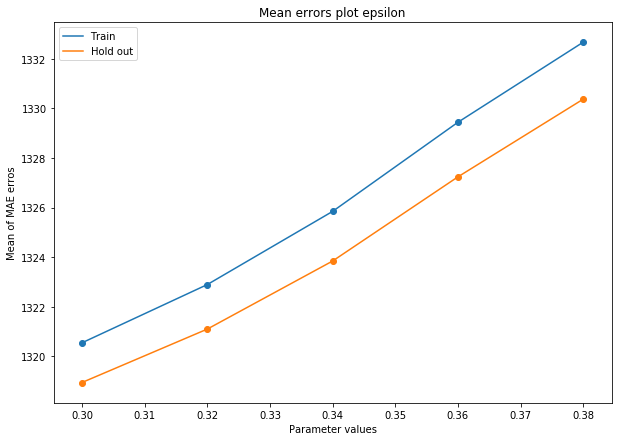

In [42]:
est=SGDRegressor(loss='huber',
                 eta0=0.001,
                early_stopping=True,
                random_state=16)
params={'epsilon':[i/100 for i in range(30,40,2)]}

model_fit(estimator=est,params=params,folds=5)

### 5.3 l1 ratio

Best params: {'l1_ratio': 0.0} Best score: 1318.9378221645588 Mean train score: 1320.5401044955795


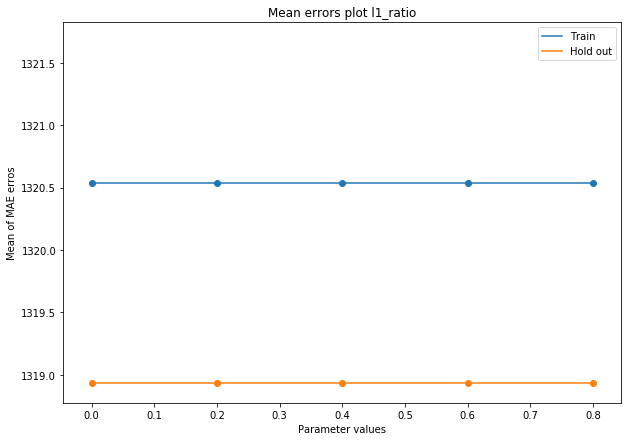

In [44]:
est=SGDRegressor(loss='huber',
                 eta0=0.001,
                 epsilon=0.3,
                early_stopping=True,
                random_state=16)
params={'l1_ratio':[i/10 for i in range(0,10,2)]}

model_fit(estimator=est,params=params,folds=5)

In [45]:
reg=SGDRegressor(loss='huber',
                eta0=0.001,
                epsilon=0.3,
                l1_ratio=0,
                early_stopping=True,
                random_state=16)
reg.fit(np.array(X),np.array(y))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,'submissions/third/SGD_huber_submission.csv')

File saved


#### Kaggle submission
<img src='submissions/third/SGD_huber_submission.png'>

## 6 Random Forest <br>
### n_estimators

Best params: {'n_estimators': 400} Best score: 1207.6131485980434 Mean train score: 466.97360503432293


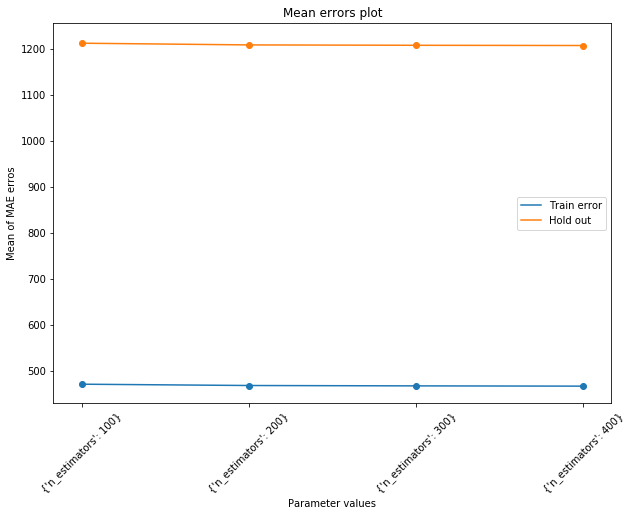

In [35]:
est=RandomForestRegressor(n_jobs=-1,
                         random_state=16)
params={'n_estimators':[100,200,300,400]}
model_fit(estimator=est,params=params,folds=3)

In [36]:
reg=RandomForestRegressor(n_jobs=-1,
                          n_estimators=400,
                         random_state=16)
reg.fit(np.array(X),np.array(y))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,'submissions/third/random_forest_submission.csv')

File saved


#### Kaggle submission
<img src='submissions/third/random_forest_submission.png'>

## 7. xgboost

In [68]:
def custom_eval(predt: np.ndarray, dtrain: xgb.DMatrix):
    """Find absolute mean error of predicted values in the original scale"""
    y=dtrain.get_label()
    y=list(map(lambda val:(val**4)-1,y))
    predt=list(map(lambda val:(val**4)-1,predt))
    error=mae(y,predt)
    return 'Error', error

In [69]:
def xgb_cv_fit(estimator,tr_data=X_tr,cv_data=X_cv,cv=3,stopping_rounds=3):
    '''Uses K fold cross validation to cross validate xgboost estimator parameter.'''
    params=estimator.get_xgb_params()
    Dtrain=xgb.DMatrix(data=np.array(tr_data),label=np.array(y_tr))
    n_rounds=params['n_estimators']
    
    cvresults=xgb.cv(params=params,
            num_boost_round=n_rounds,
            nfold=cv,
            dtrain=Dtrain,
            feval=custom_eval,
            early_stopping_rounds=stopping_rounds,
            verbose_eval=True)
    
    n_rounds=cvresults.shape[0]
    
    estimator.set_params(n_estimators=n_rounds)
    estimator.fit(X=tr_data,
                  y=y_tr,
                  eval_set=[(cv_data,y_cv)],
                 eval_metric=custom_eval)
    pickle.dump(estimator,open('models/model_rounds_{0}'.format(n_rounds),'wb'))
    
    
    pred=estimator.predict(cv_data)
    pred=list(map(lambda val:(val**4)-1,pred))
    
    y=list(map(lambda val:(val**4)-1,y_cv))
    
    print('MAE:',mae(y,pred),'Number of estimators:',n_rounds)

### 7.1 max depth

In [35]:
est=xgb.XGBRegressor(n_estimators=10000,
                     max_depth=1,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
xgb_cv_fit(est)

[0]	train-Error:2832.29+2.27033	train-rmse:3.48698+0.00119778	test-Error:2832.29+5.16941	test-rmse:3.48698+0.00607256
[1]	train-Error:2200.38+1.7301	train-rmse:2.0408+0.000704616	test-Error:2200.37+7.01384	test-rmse:2.04079+0.00705556
[2]	train-Error:1736.54+1.48951	train-rmse:1.44945+0.0009116	test-Error:1736.95+6.33168	test-rmse:1.44954+0.00607455
[3]	train-Error:1546.32+1.9009	train-rmse:1.24329+0.00116891	test-Error:1546.97+6.24676	test-rmse:1.24347+0.00454284
[4]	train-Error:1472.21+2.5129	train-rmse:1.17236+0.00134151	test-Error:1472.83+5.29066	test-rmse:1.17257+0.00323351
[5]	train-Error:1435.85+3.79184	train-rmse:1.14511+0.00171405	test-Error:1437.29+5.219	test-rmse:1.14586+0.00288638
[6]	train-Error:1413.61+2.40873	train-rmse:1.12978+0.00165003	test-Error:1414.02+3.08195	test-rmse:1.12999+0.00267803
[7]	train-Error:1402.17+2.63957	train-rmse:1.12004+0.00195748	test-Error:1402.6+2.56551	test-rmse:1.12026+0.00284681
[8]	train-Error:1393.23+2.08231	train-rmse:1.1116+0.00186784	te

[70]	train-Error:1242.2+2.48387	train-rmse:0.994634+0.0016624	test-Error:1244.37+4.26136	test-rmse:0.996235+0.00324659
[71]	train-Error:1241.74+2.51587	train-rmse:0.994366+0.0016716	test-Error:1243.93+4.34418	test-rmse:0.995967+0.00330121
[72]	train-Error:1241.51+2.4208	train-rmse:0.994115+0.00165332	test-Error:1243.81+4.39417	test-rmse:0.995764+0.00326803
[73]	train-Error:1241.2+2.37208	train-rmse:0.993886+0.00164325	test-Error:1243.43+4.45461	test-rmse:0.995557+0.00327602
[74]	train-Error:1240.9+2.43088	train-rmse:0.993649+0.00165722	test-Error:1243.22+4.4327	test-rmse:0.99532+0.00325229
[75]	train-Error:1240.57+2.542	train-rmse:0.993435+0.00165272	test-Error:1243.02+4.383	test-rmse:0.995209+0.0032742
[76]	train-Error:1240.35+2.38853	train-rmse:0.99323+0.00163665	test-Error:1242.79+4.58157	test-rmse:0.995029+0.00323341
[77]	train-Error:1240.09+2.44285	train-rmse:0.993021+0.0016426	test-Error:1242.55+4.5956	test-rmse:0.994884+0.0032431
[78]	train-Error:1239.91+2.47534	train-rmse:0.992

[138]	train-Error:1232.19+1.98338	train-rmse:0.98622+0.00133494	test-Error:1235.26+4.86174	test-rmse:0.988584+0.00359454
[139]	train-Error:1232.14+1.98136	train-rmse:0.986165+0.00133413	test-Error:1235.23+4.88455	test-rmse:0.988513+0.00358678
[140]	train-Error:1232.07+1.92715	train-rmse:0.986107+0.001336	test-Error:1235.21+4.84986	test-rmse:0.988496+0.00356201
[141]	train-Error:1232.06+1.89908	train-rmse:0.986054+0.00133637	test-Error:1235.18+4.84995	test-rmse:0.988435+0.00353925
[142]	train-Error:1232.09+1.8893	train-rmse:0.985997+0.00134347	test-Error:1235.23+4.83788	test-rmse:0.98839+0.00352588
[143]	train-Error:1232.01+1.85225	train-rmse:0.98594+0.00134454	test-Error:1235.14+4.84914	test-rmse:0.98831+0.00347774
[144]	train-Error:1231.99+1.83806	train-rmse:0.985884+0.00133863	test-Error:1235.09+4.84781	test-rmse:0.988262+0.00349205
[145]	train-Error:1231.9+1.79207	train-rmse:0.98582+0.00133001	test-Error:1235.04+4.81835	test-rmse:0.988202+0.00345892
[146]	train-Error:1231.87+1.80912

[206]	train-Error:1229.19+1.79788	train-rmse:0.983486+0.00132368	test-Error:1232.85+4.73133	test-rmse:0.98631+0.00343813
[207]	train-Error:1229.15+1.78205	train-rmse:0.983459+0.00132448	test-Error:1232.8+4.7539	test-rmse:0.986278+0.00344607
[208]	train-Error:1229.09+1.79344	train-rmse:0.983432+0.00132409	test-Error:1232.82+4.77273	test-rmse:0.986285+0.00346118
[209]	train-Error:1229.09+1.80893	train-rmse:0.983404+0.00132412	test-Error:1232.8+4.73623	test-rmse:0.986239+0.00347027
[210]	train-Error:1229.04+1.77124	train-rmse:0.983376+0.00132204	test-Error:1232.73+4.81822	test-rmse:0.986209+0.00348804
[211]	train-Error:1229+1.74473	train-rmse:0.983348+0.00132203	test-Error:1232.67+4.81574	test-rmse:0.986176+0.00347118
[212]	train-Error:1228.91+1.66113	train-rmse:0.983318+0.00131955	test-Error:1232.69+4.72907	test-rmse:0.986156+0.00346646
[213]	train-Error:1228.82+1.64093	train-rmse:0.983292+0.00132076	test-Error:1232.76+4.7738	test-rmse:0.986209+0.00350916
[214]	train-Error:1228.84+1.6787

[122]	validation_0-rmse:0.987714	validation_0-Error:1237.06
[123]	validation_0-rmse:0.987685	validation_0-Error:1237.01
[124]	validation_0-rmse:0.987623	validation_0-Error:1236.95
[125]	validation_0-rmse:0.987506	validation_0-Error:1236.83
[126]	validation_0-rmse:0.987506	validation_0-Error:1236.83
[127]	validation_0-rmse:0.987476	validation_0-Error:1236.95
[128]	validation_0-rmse:0.987433	validation_0-Error:1236.91
[129]	validation_0-rmse:0.987407	validation_0-Error:1236.72
[130]	validation_0-rmse:0.98738	validation_0-Error:1236.73
[131]	validation_0-rmse:0.98732	validation_0-Error:1236.69
[132]	validation_0-rmse:0.987204	validation_0-Error:1236.54
[133]	validation_0-rmse:0.987166	validation_0-Error:1236.6
[134]	validation_0-rmse:0.98706	validation_0-Error:1236.6
[135]	validation_0-rmse:0.987087	validation_0-Error:1236.62
[136]	validation_0-rmse:0.987062	validation_0-Error:1236.56
[137]	validation_0-rmse:0.986994	validation_0-Error:1236.52
[138]	validation_0-rmse:0.986886	validation_0

Best params: {'max_depth': 4} Best score: 1178.982039680791 Mean train score: 1101.9253081613158


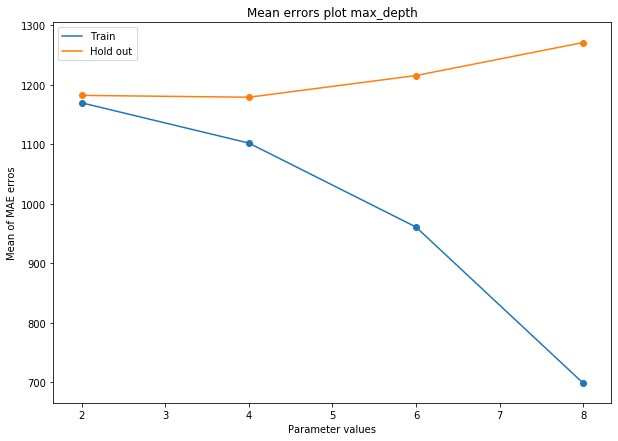

In [36]:
est=xgb.XGBRegressor(n_estimators=213, # Obtained from previous step
                     max_depth=1,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'max_depth':[i for i in range(2,10,2)]}
model_fit(estimator=est,params=params,folds=5)

Best params: {'max_depth': 3} Best score: 1173.618457295614 Mean train score: 1139.6427627873845


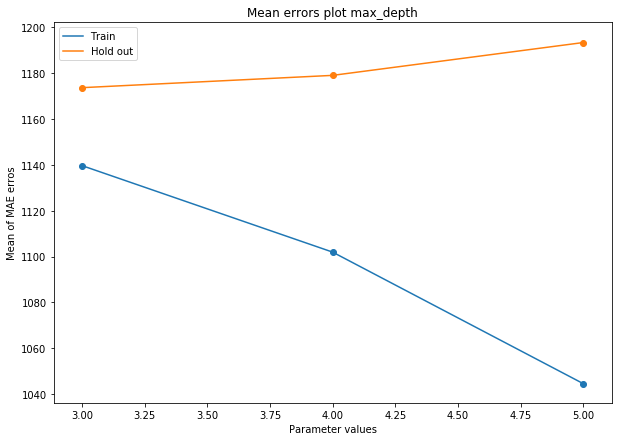

In [37]:
est=xgb.XGBRegressor(n_estimators=213, # Obtained from previous step
                     max_depth=1,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'max_depth':[3,4,5]}
model_fit(estimator=est,params=params,folds=5)

#### Recalibrate boosting rounds

In [38]:
est=xgb.XGBRegressor(n_estimators=10000, # Obtained from previous step
                     max_depth=3,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
xgb_cv_fit(est)

[0]	train-Error:2827.01+2.33903	train-rmse:3.46263+0.00140907	test-Error:2827+5.20488	test-rmse:3.4628+0.0064138
[1]	train-Error:2166.78+2.08008	train-rmse:1.98493+0.00136721	test-Error:2167.01+7.14635	test-rmse:1.98556+0.00749428
[2]	train-Error:1656.73+2.8432	train-rmse:1.37505+0.00209146	test-Error:1657.68+7.23316	test-rmse:1.3763+0.0067504
[3]	train-Error:1432.14+2.18497	train-rmse:1.15443+0.000928293	test-Error:1434.16+6.25085	test-rmse:1.15653+0.00599712
[4]	train-Error:1345.16+1.11554	train-rmse:1.07788+0.000549214	test-Error:1347.77+6.43106	test-rmse:1.08009+0.00558051
[5]	train-Error:1306.92+1.57392	train-rmse:1.04834+0.00128281	test-Error:1308.9+6.74516	test-rmse:1.05024+0.00495809
[6]	train-Error:1287.23+2.98343	train-rmse:1.03319+0.00182566	test-Error:1290.44+6.73726	test-rmse:1.03578+0.00451337
[7]	train-Error:1274.13+3.35204	train-rmse:1.02267+0.00206366	test-Error:1278.08+5.76172	test-rmse:1.02606+0.00415619
[8]	train-Error:1261.02+1.5809	train-rmse:1.01331+0.000579201	t

[69]	train-Error:1169.25+2.15357	train-rmse:0.947182+0.00116132	test-Error:1190.85+6.65972	test-rmse:0.96272+0.00418147
[70]	train-Error:1168.93+2.20627	train-rmse:0.94692+0.00119052	test-Error:1190.82+6.53289	test-rmse:0.962676+0.00412917
[71]	train-Error:1168.7+2.18511	train-rmse:0.946706+0.00114918	test-Error:1190.83+6.56449	test-rmse:0.962649+0.00416012
[72]	train-Error:1168.11+2.03096	train-rmse:0.946315+0.00117975	test-Error:1190.45+6.66094	test-rmse:0.962402+0.00410279
[73]	train-Error:1167.47+1.98809	train-rmse:0.945938+0.00120944	test-Error:1190.14+6.48036	test-rmse:0.962255+0.00401631
[74]	train-Error:1166.96+1.99261	train-rmse:0.945542+0.00108142	test-Error:1189.9+6.65844	test-rmse:0.96201+0.00417158
[75]	train-Error:1166.61+2.11795	train-rmse:0.945249+0.00115512	test-Error:1189.79+6.82621	test-rmse:0.961909+0.00431701
[76]	train-Error:1166.2+2.1163	train-rmse:0.944944+0.00113182	test-Error:1189.58+6.74093	test-rmse:0.96175+0.004204
[77]	train-Error:1165.94+2.11503	train-rms

[137]	train-Error:1145.84+1.95148	train-rmse:0.931055+0.000880495	test-Error:1183.76+6.57534	test-rmse:0.95807+0.00389338
[0]	validation_0-rmse:3.45793	validation_0-Error:2823.7
[1]	validation_0-rmse:1.98174	validation_0-Error:2163.28
[2]	validation_0-rmse:1.37371	validation_0-Error:1655.34
[3]	validation_0-rmse:1.15652	validation_0-Error:1433.71
[4]	validation_0-rmse:1.0814	validation_0-Error:1352.13
[5]	validation_0-rmse:1.05111	validation_0-Error:1312.76
[6]	validation_0-rmse:1.03439	validation_0-Error:1290.14
[7]	validation_0-rmse:1.02356	validation_0-Error:1275.06
[8]	validation_0-rmse:1.01551	validation_0-Error:1263.55
[9]	validation_0-rmse:1.01046	validation_0-Error:1256.24
[10]	validation_0-rmse:1.00361	validation_0-Error:1246.66
[11]	validation_0-rmse:0.998656	validation_0-Error:1240.21
[12]	validation_0-rmse:0.994174	validation_0-Error:1234.85
[13]	validation_0-rmse:0.991724	validation_0-Error:1231.2
[14]	validation_0-rmse:0.989134	validation_0-Error:1228.91
[15]	validation_0

### 7.2 min_child_weight and gamma

Best params: {'gamma': 0.2, 'min_child_weight': 3} Best score: 1179.8766400749703 Mean train score: 1151.5390475740978


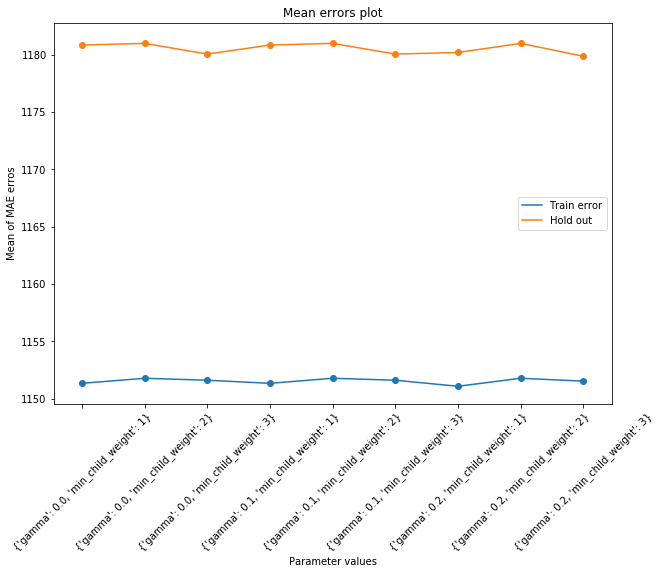

In [56]:
est=xgb.XGBRegressor(n_estimators=136,
                     max_depth=3,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'min_child_weight':[1,2,3], 'gamma':[0.0,0.1,0.2]}
model_fit(estimator=est,params=params,folds=3)

Best params: {'gamma': 0.3, 'min_child_weight': 4} Best score: 1179.2301702330012 Mean train score: 1151.3267927583245


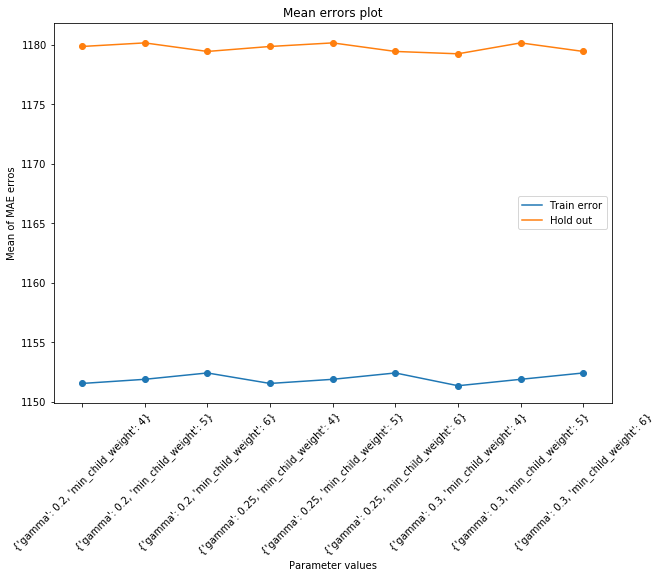

In [57]:
est=xgb.XGBRegressor(n_estimators=136,
                     max_depth=3,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'min_child_weight':[4,5,6], 'gamma':[0.2,0.25,0.3]}
model_fit(estimator=est,params=params,folds=3)

Best params: {'gamma': 0.3, 'min_child_weight': 4} Best score: 1179.2301702330012 Mean train score: 1151.3267927583245


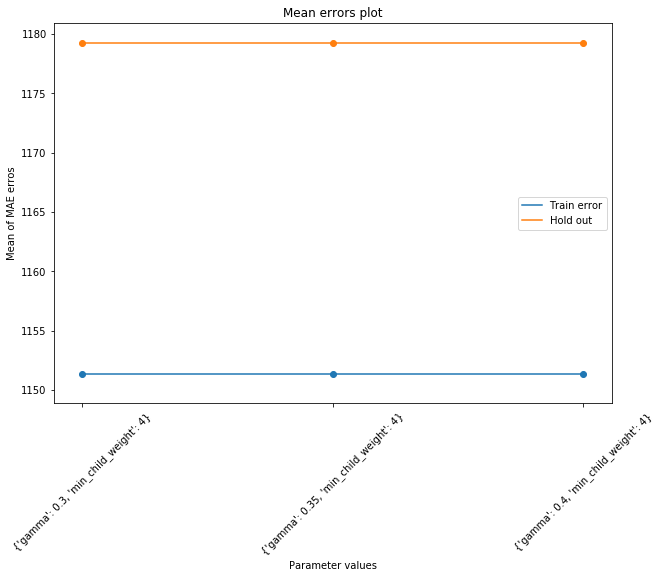

In [59]:
est=xgb.XGBRegressor(n_estimators=136,
                     max_depth=3,
                     learning_rate=0.5,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'min_child_weight':[4], 'gamma':[0.3,0.35,0.4]}
model_fit(estimator=est,params=params,folds=3)

#### Recalibrate boosting rounds

In [60]:
est=xgb.XGBRegressor(n_estimators=10000, # Obtained from previous step
                     max_depth=3,
                     learning_rate=0.5,
                     min_child_weight=4,
                     gamma=0.3,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
xgb_cv_fit(est)

[0]	train-Error:2827.01+2.33903	train-rmse:3.46263+0.00140907	test-Error:2827+5.20488	test-rmse:3.4628+0.00641388
[1]	train-Error:2166.78+2.08008	train-rmse:1.98493+0.00136721	test-Error:2167.01+7.14635	test-rmse:1.98556+0.00749428
[2]	train-Error:1656.73+2.8432	train-rmse:1.37505+0.00209146	test-Error:1657.68+7.23316	test-rmse:1.3763+0.0067504
[3]	train-Error:1432.14+2.18497	train-rmse:1.15443+0.000928293	test-Error:1434.16+6.25085	test-rmse:1.15653+0.00599712
[4]	train-Error:1345.16+1.11554	train-rmse:1.07788+0.000549214	test-Error:1347.77+6.43106	test-rmse:1.08009+0.00558051
[5]	train-Error:1306.92+1.57392	train-rmse:1.04834+0.00128281	test-Error:1308.9+6.74516	test-rmse:1.05024+0.00495809
[6]	train-Error:1287.23+2.98343	train-rmse:1.03319+0.00182566	test-Error:1290.44+6.73726	test-rmse:1.03578+0.00451337
[7]	train-Error:1274.13+3.35204	train-rmse:1.02267+0.00206334	test-Error:1278.08+5.76172	test-rmse:1.02606+0.00415621
[8]	train-Error:1261.02+1.5809	train-rmse:1.01331+0.000579201	

[69]	train-Error:1168.73+1.11442	train-rmse:0.947032+0.000471573	test-Error:1190.24+7.52212	test-rmse:0.961671+0.00468456
[70]	train-Error:1168.05+1.35449	train-rmse:0.946663+0.000517977	test-Error:1190.1+7.50881	test-rmse:0.961687+0.0046741
[71]	train-Error:1167.76+1.18905	train-rmse:0.946416+0.000430772	test-Error:1189.96+7.52355	test-rmse:0.961568+0.00463156
[72]	train-Error:1167.36+1.1661	train-rmse:0.946146+0.000451243	test-Error:1190.03+7.42328	test-rmse:0.961484+0.00450734
[73]	train-Error:1167.13+1.07703	train-rmse:0.945984+0.000404866	test-Error:1189.97+7.38815	test-rmse:0.961445+0.00450292
[74]	train-Error:1166.81+1.18242	train-rmse:0.945736+0.000421504	test-Error:1189.82+7.53091	test-rmse:0.961324+0.004561
[75]	train-Error:1166.51+1.21794	train-rmse:0.945501+0.000456378	test-Error:1189.65+7.74633	test-rmse:0.961216+0.004599
[76]	train-Error:1166.22+1.18184	train-rmse:0.945258+0.00042913	test-Error:1189.56+7.76133	test-rmse:0.961136+0.00460844
[77]	train-Error:1165.85+1.36093

[12]	validation_0-rmse:0.994174	validation_0-Error:1234.85
[13]	validation_0-rmse:0.991724	validation_0-Error:1231.2
[14]	validation_0-rmse:0.989134	validation_0-Error:1228.91
[15]	validation_0-rmse:0.987097	validation_0-Error:1225.49
[16]	validation_0-rmse:0.982323	validation_0-Error:1220.57
[17]	validation_0-rmse:0.980781	validation_0-Error:1218.27
[18]	validation_0-rmse:0.979229	validation_0-Error:1216.09
[19]	validation_0-rmse:0.978093	validation_0-Error:1214.96
[20]	validation_0-rmse:0.97628	validation_0-Error:1212.89
[21]	validation_0-rmse:0.975087	validation_0-Error:1211.65
[22]	validation_0-rmse:0.974138	validation_0-Error:1210.18
[23]	validation_0-rmse:0.97338	validation_0-Error:1209.26
[24]	validation_0-rmse:0.972193	validation_0-Error:1207.3
[25]	validation_0-rmse:0.971402	validation_0-Error:1206.49
[26]	validation_0-rmse:0.971011	validation_0-Error:1206.31
[27]	validation_0-rmse:0.970502	validation_0-Error:1205.04
[28]	validation_0-rmse:0.969959	validation_0-Error:1204.18
[

### 7.3 column sample by tree and column sample by level

Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 0.8} Best score: 1178.9373164156916 Mean train score: 1152.0046931616569


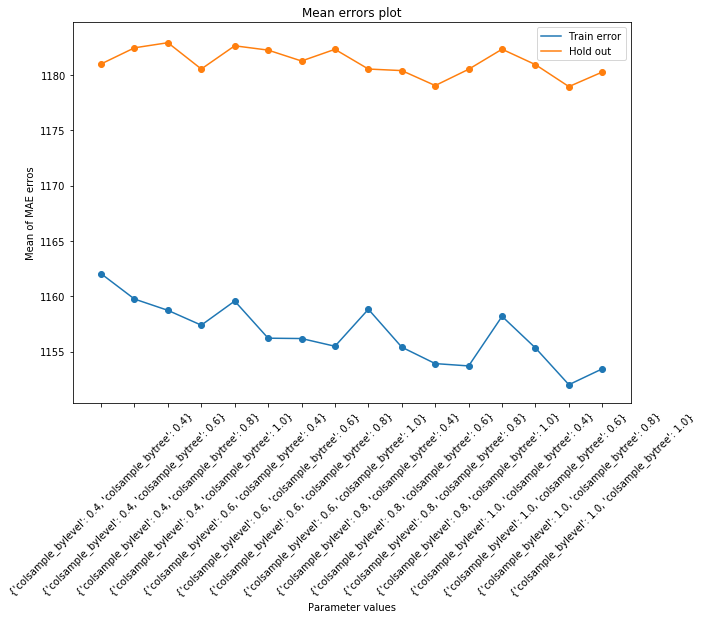

In [10]:
est=xgb.XGBRegressor(n_estimators=129, # Obtained from previous step
                     max_depth=3,
                     learning_rate=0.5,
                     min_child_weight=4,
                     gamma=0.3,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'colsample_bytree':[i/10 for i in range(4,11,2)], 'colsample_bylevel':[i/10 for i in range(4,11,2)]}
model_fit(estimator=est,params=params,folds=3)

Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 0.8} Best score: 1178.9373164156916 Mean train score: 1152.0046931616569


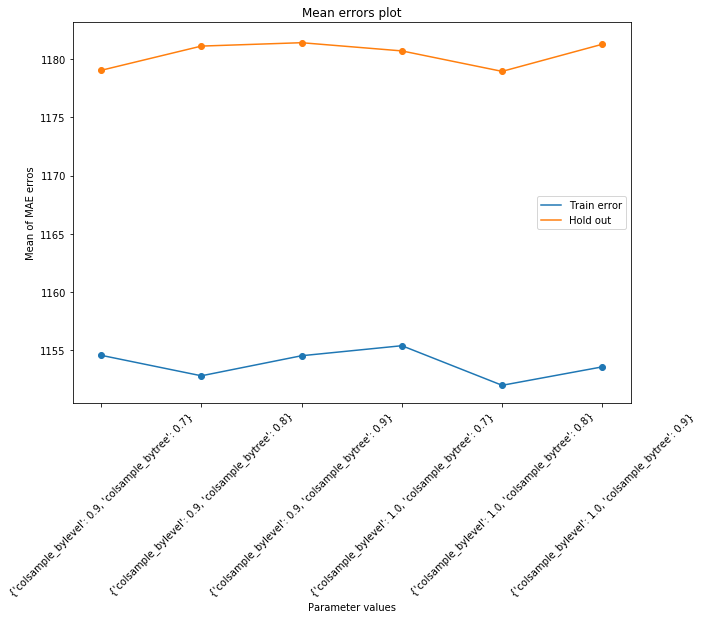

In [11]:
est=xgb.XGBRegressor(n_estimators=129, # Obtained from previous step
                     max_depth=3,
                     learning_rate=0.5,
                     min_child_weight=4,
                     gamma=0.3,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
params={'colsample_bytree':[0.7,0.8,0.9], 'colsample_bylevel':[0.9,1.0]}
model_fit(estimator=est,params=params,folds=3)

### 7.4 Reducing learning rate

In [13]:
est=xgb.XGBRegressor(n_estimators=10000, # Obtained from previous step
                     max_depth=3,
                     learning_rate=0.01,
                     min_child_weight=4,
                     gamma=0.3,
                     colsample_bytree=0.8,
                     colsample_bylevel=1.0,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)
xgb_cv_fit(est)

[0]	train-Error:3038.8+2.4206	train-rmse:6.56831+0.00199894	test-Error:3038.8+4.84125	test-rmse:6.56831+0.00404507
[1]	train-Error:3038.74+2.42058	train-rmse:6.50465+0.001985	test-Error:3038.74+4.84129	test-rmse:6.50465+0.00406713
[2]	train-Error:3038.67+2.42055	train-rmse:6.44164+0.00196867	test-Error:3038.67+4.84133	test-rmse:6.44165+0.00408825
[3]	train-Error:3038.57+2.42054	train-rmse:6.37929+0.00195905	test-Error:3038.57+4.84136	test-rmse:6.3793+0.00409888
[4]	train-Error:3038.44+2.42052	train-rmse:6.31758+0.00194348	test-Error:3038.44+4.84142	test-rmse:6.31759+0.00412407
[5]	train-Error:3038.29+2.42048	train-rmse:6.2565+0.0019286	test-Error:3038.29+4.8415	test-rmse:6.25652+0.00414439
[6]	train-Error:3038.1+2.42048	train-rmse:6.19606+0.00191303	test-Error:3038.1+4.84152	test-rmse:6.19608+0.00416122
[7]	train-Error:3037.87+2.42021	train-rmse:6.13624+0.00189315	test-Error:3037.87+4.84185	test-rmse:6.13626+0.00418545
[8]	train-Error:3037.6+2.4201	train-rmse:6.07704+0.00187874	test-Er

[70]	train-Error:2813.38+2.23175	train-rmse:3.39648+0.00136447	test-Error:2813.38+5.16662	test-rmse:3.39661+0.0059933
[71]	train-Error:2805.74+2.22768	train-rmse:3.36623+0.00135979	test-Error:2805.74+5.17695	test-rmse:3.36637+0.00601738
[72]	train-Error:2797.98+2.22475	train-rmse:3.33632+0.00135869	test-Error:2797.99+5.18988	test-rmse:3.33646+0.00603555
[73]	train-Error:2790.12+2.21546	train-rmse:3.30674+0.00135412	test-Error:2790.13+5.20709	test-rmse:3.30689+0.00606197
[74]	train-Error:2782.15+2.2124	train-rmse:3.27748+0.00134503	test-Error:2782.15+5.22057	test-rmse:3.27764+0.006083
[75]	train-Error:2774.06+2.20399	train-rmse:3.24855+0.00134739	test-Error:2774.06+5.23805	test-rmse:3.2487+0.00610151
[76]	train-Error:2765.87+2.195	train-rmse:3.21994+0.00134378	test-Error:2765.88+5.26348	test-rmse:3.22009+0.00614161
[77]	train-Error:2757.59+2.19855	train-rmse:3.19165+0.00133359	test-Error:2757.59+5.27356	test-rmse:3.19181+0.00617238
[78]	train-Error:2749.2+2.19386	train-rmse:3.16367+0.00

[139]	train-Error:2148.93+2.21441	train-rmse:1.94676+0.00143464	test-Error:2149.1+6.4761	test-rmse:1.94728+0.00689624
[140]	train-Error:2139.22+2.20951	train-rmse:1.93339+0.00147351	test-Error:2139.39+6.49571	test-rmse:1.9339+0.00687154
[141]	train-Error:2129.55+2.20899	train-rmse:1.92016+0.00144221	test-Error:2129.73+6.51658	test-rmse:1.92068+0.00690107
[142]	train-Error:2119.94+2.20232	train-rmse:1.90711+0.00147187	test-Error:2120.12+6.54107	test-rmse:1.90764+0.00688268
[143]	train-Error:2110.38+2.19992	train-rmse:1.89421+0.0014419	test-Error:2110.58+6.5647	test-rmse:1.89476+0.00691467
[144]	train-Error:2100.89+2.20576	train-rmse:1.88151+0.00148192	test-Error:2101.08+6.56925	test-rmse:1.88206+0.00687973
[145]	train-Error:2091.43+2.19355	train-rmse:1.86894+0.00144854	test-Error:2091.64+6.5776	test-rmse:1.86951+0.00690577
[146]	train-Error:2082.04+2.20493	train-rmse:1.85654+0.00146952	test-Error:2082.25+6.57536	test-rmse:1.85711+0.00686101
[147]	train-Error:2072.71+2.21501	train-rmse:1

[208]	train-Error:1634.62+2.64396	train-rmse:1.3416+0.00171179	test-Error:1635.49+6.34658	test-rmse:1.34273+0.00632936
[209]	train-Error:1629.6+2.67592	train-rmse:1.3365+0.00172214	test-Error:1630.48+6.27968	test-rmse:1.33764+0.00630478
[210]	train-Error:1624.65+2.65751	train-rmse:1.33148+0.00172586	test-Error:1625.53+6.31232	test-rmse:1.33261+0.00629526
[211]	train-Error:1619.75+2.74346	train-rmse:1.32654+0.00175411	test-Error:1620.66+6.23224	test-rmse:1.32769+0.00625954
[212]	train-Error:1614.9+2.79724	train-rmse:1.32166+0.0017584	test-Error:1615.83+6.15919	test-rmse:1.32283+0.00624426
[213]	train-Error:1610.17+2.77303	train-rmse:1.31687+0.00176777	test-Error:1611.13+6.19014	test-rmse:1.31807+0.00623423
[214]	train-Error:1605.45+2.78428	train-rmse:1.31214+0.00177371	test-Error:1606.42+6.12484	test-rmse:1.31335+0.00619818
[215]	train-Error:1600.82+2.7182	train-rmse:1.3075+0.00175785	test-Error:1601.79+6.19331	test-rmse:1.30871+0.00620405
[216]	train-Error:1596.29+2.72978	train-rmse:1.

[277]	train-Error:1407.91+2.86758	train-rmse:1.12467+0.001975	test-Error:1409.69+5.10489	test-rmse:1.12652+0.00494588
[278]	train-Error:1405.97+2.86098	train-rmse:1.12297+0.00199016	test-Error:1407.78+5.0666	test-rmse:1.12483+0.00491245
[279]	train-Error:1404.01+2.83553	train-rmse:1.12126+0.0019649	test-Error:1405.83+5.07994	test-rmse:1.12313+0.00492655
[280]	train-Error:1402.07+2.82616	train-rmse:1.11959+0.00193657	test-Error:1403.91+5.1236	test-rmse:1.12147+0.00495726
[281]	train-Error:1400.21+2.82911	train-rmse:1.11795+0.00193035	test-Error:1402.07+5.11079	test-rmse:1.11983+0.00493987
[282]	train-Error:1398.3+2.84712	train-rmse:1.11632+0.00193287	test-Error:1400.16+5.10199	test-rmse:1.11821+0.00492476
[283]	train-Error:1396.47+2.85494	train-rmse:1.11473+0.00193798	test-Error:1398.33+5.1081	test-rmse:1.11663+0.00491162
[284]	train-Error:1394.63+2.82737	train-rmse:1.11315+0.00193079	test-Error:1396.51+5.06104	test-rmse:1.11506+0.00488329
[285]	train-Error:1392.89+2.86908	train-rmse:1.

[346]	train-Error:1317.61+2.75004	train-rmse:1.0499+0.0017837	test-Error:1320.23+4.65232	test-rmse:1.05242+0.00420538
[347]	train-Error:1316.81+2.74341	train-rmse:1.04929+0.00178267	test-Error:1319.44+4.64961	test-rmse:1.05183+0.00419023
[348]	train-Error:1315.86+2.72733	train-rmse:1.04859+0.0017829	test-Error:1318.5+4.68101	test-rmse:1.05112+0.00418867
[349]	train-Error:1315.15+2.73059	train-rmse:1.04799+0.0017766	test-Error:1317.81+4.67522	test-rmse:1.05055+0.00418856
[350]	train-Error:1314.33+2.73035	train-rmse:1.04738+0.00178262	test-Error:1317+4.64447	test-rmse:1.04994+0.00416776
[351]	train-Error:1313.53+2.73709	train-rmse:1.04677+0.00177121	test-Error:1316.21+4.59926	test-rmse:1.04934+0.00415803
[352]	train-Error:1312.7+2.74055	train-rmse:1.04616+0.00175965	test-Error:1315.39+4.63261	test-rmse:1.04874+0.00418117
[353]	train-Error:1311.95+2.78398	train-rmse:1.04559+0.00175512	test-Error:1314.65+4.58418	test-rmse:1.04819+0.00416953
[354]	train-Error:1311.07+2.79262	train-rmse:1.04

[415]	train-Error:1276.04+2.515	train-rmse:1.01961+0.00173828	test-Error:1279.49+4.24807	test-rmse:1.0227+0.00378354
[416]	train-Error:1275.62+2.47897	train-rmse:1.01931+0.00172437	test-Error:1279.08+4.32621	test-rmse:1.02241+0.00381308
[417]	train-Error:1275.21+2.4551	train-rmse:1.01902+0.00171804	test-Error:1278.68+4.33094	test-rmse:1.02212+0.00381096
[418]	train-Error:1274.78+2.48786	train-rmse:1.01872+0.00174222	test-Error:1278.26+4.27344	test-rmse:1.02182+0.00377771
[419]	train-Error:1274.4+2.4739	train-rmse:1.01845+0.00173393	test-Error:1277.9+4.27633	test-rmse:1.02156+0.00378029
[420]	train-Error:1273.93+2.41602	train-rmse:1.01814+0.00171884	test-Error:1277.43+4.32089	test-rmse:1.02125+0.00379163
[421]	train-Error:1273.53+2.45303	train-rmse:1.01787+0.00172494	test-Error:1277.04+4.27186	test-rmse:1.02098+0.003782
[422]	train-Error:1273.09+2.49833	train-rmse:1.01758+0.00175181	test-Error:1276.63+4.22557	test-rmse:1.02071+0.00375056
[423]	train-Error:1272.68+2.50081	train-rmse:1.01

[484]	train-Error:1252.52+2.54555	train-rmse:1.00371+0.00185108	test-Error:1256.61+3.8024	test-rmse:1.00723+0.00352115
[485]	train-Error:1252.25+2.5839	train-rmse:1.00351+0.00186326	test-Error:1256.35+3.77144	test-rmse:1.00704+0.00350912
[486]	train-Error:1251.98+2.57448	train-rmse:1.00333+0.00185907	test-Error:1256.09+3.79677	test-rmse:1.00686+0.00351773
[487]	train-Error:1251.77+2.57534	train-rmse:1.00317+0.00185512	test-Error:1255.89+3.7992	test-rmse:1.00671+0.00352351
[488]	train-Error:1251.47+2.57307	train-rmse:1.003+0.00185598	test-Error:1255.6+3.79315	test-rmse:1.00654+0.00352058
[489]	train-Error:1251.21+2.56675	train-rmse:1.00282+0.00186354	test-Error:1255.36+3.77478	test-rmse:1.00638+0.00351248
[490]	train-Error:1250.94+2.58028	train-rmse:1.00264+0.00188107	test-Error:1255.09+3.75019	test-rmse:1.0062+0.00348953
[491]	train-Error:1250.68+2.56202	train-rmse:1.00246+0.00187386	test-Error:1254.84+3.79033	test-rmse:1.00603+0.00350025
[492]	train-Error:1250.47+2.55425	train-rmse:1.

[553]	train-Error:1237.11+2.54367	train-rmse:0.993436+0.00193405	test-Error:1241.79+3.54854	test-rmse:0.997394+0.00342702
[554]	train-Error:1236.91+2.54983	train-rmse:0.99331+0.00193162	test-Error:1241.59+3.5452	test-rmse:0.997264+0.00343027
[555]	train-Error:1236.73+2.528	train-rmse:0.993191+0.00192238	test-Error:1241.44+3.57934	test-rmse:0.997154+0.00343952
[556]	train-Error:1236.55+2.53871	train-rmse:0.99306+0.00193934	test-Error:1241.25+3.54793	test-rmse:0.997029+0.00342131
[557]	train-Error:1236.33+2.51801	train-rmse:0.992914+0.00192937	test-Error:1241.05+3.56782	test-rmse:0.996889+0.00343192
[558]	train-Error:1236.15+2.53705	train-rmse:0.992786+0.00193676	test-Error:1240.87+3.54873	test-rmse:0.996771+0.0034215
[559]	train-Error:1235.98+2.50961	train-rmse:0.99267+0.00192466	test-Error:1240.72+3.55508	test-rmse:0.996661+0.00343284
[560]	train-Error:1235.8+2.5016	train-rmse:0.99255+0.00192653	test-Error:1240.55+3.56817	test-rmse:0.996546+0.00342686
[561]	train-Error:1235.6+2.51272	t

[621]	train-Error:1225.42+2.43703	train-rmse:0.98564+0.00194022	test-Error:1230.63+3.50428	test-rmse:0.989955+0.00343694
[622]	train-Error:1225.27+2.43106	train-rmse:0.985531+0.0019369	test-Error:1230.49+3.50022	test-rmse:0.989856+0.00343652
[623]	train-Error:1225.11+2.44547	train-rmse:0.985431+0.00193696	test-Error:1230.34+3.48981	test-rmse:0.989759+0.00343776
[624]	train-Error:1224.95+2.44711	train-rmse:0.985328+0.00193276	test-Error:1230.18+3.4787	test-rmse:0.989658+0.0034357
[625]	train-Error:1224.82+2.43996	train-rmse:0.985234+0.00192548	test-Error:1230.06+3.51494	test-rmse:0.98957+0.00345172
[626]	train-Error:1224.65+2.43832	train-rmse:0.98514+0.00192806	test-Error:1229.91+3.51396	test-rmse:0.98948+0.00345023
[627]	train-Error:1224.5+2.42989	train-rmse:0.985028+0.00192221	test-Error:1229.76+3.52621	test-rmse:0.989375+0.0034586
[628]	train-Error:1224.36+2.43864	train-rmse:0.984936+0.00192227	test-Error:1229.61+3.50943	test-rmse:0.989285+0.00345603
[629]	train-Error:1224.19+2.45017

[689]	train-Error:1216.14+2.42934	train-rmse:0.979448+0.00192473	test-Error:1221.77+3.49161	test-rmse:0.984061+0.00349064
[690]	train-Error:1216.03+2.43575	train-rmse:0.979374+0.00192692	test-Error:1221.67+3.49054	test-rmse:0.983995+0.00348717
[691]	train-Error:1215.91+2.42363	train-rmse:0.9793+0.00192646	test-Error:1221.58+3.51218	test-rmse:0.983929+0.00349332
[692]	train-Error:1215.78+2.42569	train-rmse:0.979221+0.00192512	test-Error:1221.45+3.50644	test-rmse:0.983856+0.00349143
[693]	train-Error:1215.67+2.42087	train-rmse:0.979143+0.00192152	test-Error:1221.35+3.5052	test-rmse:0.983784+0.00349098
[694]	train-Error:1215.55+2.401	train-rmse:0.979057+0.00190897	test-Error:1221.23+3.51493	test-rmse:0.983704+0.00350091
[695]	train-Error:1215.4+2.39609	train-rmse:0.978957+0.00190754	test-Error:1221.09+3.51651	test-rmse:0.983605+0.00350116
[696]	train-Error:1215.29+2.39408	train-rmse:0.978882+0.00190663	test-Error:1220.99+3.53261	test-rmse:0.983535+0.00350975
[697]	train-Error:1215.19+2.39

[757]	train-Error:1208.56+2.31954	train-rmse:0.974416+0.00189006	test-Error:1214.72+3.69417	test-rmse:0.979326+0.00357408
[758]	train-Error:1208.45+2.33424	train-rmse:0.974348+0.00188733	test-Error:1214.61+3.68105	test-rmse:0.979261+0.0035759
[759]	train-Error:1208.35+2.3347	train-rmse:0.974277+0.0018941	test-Error:1214.52+3.67021	test-rmse:0.979195+0.003565
[760]	train-Error:1208.26+2.33025	train-rmse:0.974217+0.00189391	test-Error:1214.44+3.68231	test-rmse:0.979142+0.00356636
[761]	train-Error:1208.15+2.3387	train-rmse:0.974152+0.00189413	test-Error:1214.35+3.67084	test-rmse:0.979079+0.0035674
[762]	train-Error:1208.03+2.33296	train-rmse:0.974083+0.00189207	test-Error:1214.24+3.68139	test-rmse:0.979016+0.00356995
[763]	train-Error:1207.93+2.31921	train-rmse:0.974015+0.00189121	test-Error:1214.14+3.69371	test-rmse:0.978952+0.00357231
[764]	train-Error:1207.82+2.32526	train-rmse:0.973945+0.0018917	test-Error:1214.04+3.68936	test-rmse:0.978889+0.00357311
[765]	train-Error:1207.72+2.3186

[825]	train-Error:1202.28+2.32478	train-rmse:0.970312+0.00188801	test-Error:1208.99+3.86818	test-rmse:0.97554+0.00364425
[826]	train-Error:1202.19+2.30656	train-rmse:0.970262+0.00188376	test-Error:1208.91+3.89051	test-rmse:0.975497+0.00364845
[827]	train-Error:1202.1+2.30521	train-rmse:0.970205+0.00187854	test-Error:1208.83+3.89156	test-rmse:0.975443+0.00365598
[828]	train-Error:1202.01+2.3102	train-rmse:0.970149+0.0018886	test-Error:1208.74+3.88622	test-rmse:0.975391+0.00364715
[829]	train-Error:1201.93+2.31115	train-rmse:0.9701+0.00189253	test-Error:1208.67+3.89204	test-rmse:0.975349+0.0036444
[830]	train-Error:1201.83+2.33005	train-rmse:0.970028+0.00190239	test-Error:1208.57+3.87381	test-rmse:0.975281+0.00363659
[831]	train-Error:1201.75+2.31617	train-rmse:0.969974+0.00189168	test-Error:1208.51+3.89135	test-rmse:0.975233+0.00364932
[832]	train-Error:1201.67+2.31154	train-rmse:0.969925+0.00188925	test-Error:1208.44+3.90125	test-rmse:0.975188+0.00365739
[833]	train-Error:1201.58+2.329

[893]	train-Error:1196.99+2.33604	train-rmse:0.966868+0.00188966	test-Error:1204.16+4.03844	test-rmse:0.97237+0.00371798
[894]	train-Error:1196.92+2.32623	train-rmse:0.966823+0.00188977	test-Error:1204.1+4.04698	test-rmse:0.972329+0.00371565
[895]	train-Error:1196.86+2.33363	train-rmse:0.966781+0.00189135	test-Error:1204.04+4.04034	test-rmse:0.972292+0.00371209
[896]	train-Error:1196.79+2.35671	train-rmse:0.966729+0.0019062	test-Error:1203.97+4.01623	test-rmse:0.972242+0.00369944
[897]	train-Error:1196.71+2.34957	train-rmse:0.966681+0.00190146	test-Error:1203.9+4.03367	test-rmse:0.972197+0.0037083
[898]	train-Error:1196.64+2.35156	train-rmse:0.966636+0.00190006	test-Error:1203.83+4.03526	test-rmse:0.972154+0.00371081
[899]	train-Error:1196.59+2.35794	train-rmse:0.9666+0.00190255	test-Error:1203.79+4.03102	test-rmse:0.972124+0.00370842
[900]	train-Error:1196.54+2.35188	train-rmse:0.96656+0.00190084	test-Error:1203.74+4.0455	test-rmse:0.972086+0.00371571
[901]	train-Error:1196.47+2.34762

[961]	train-Error:1192.48+2.4369	train-rmse:0.963905+0.00195726	test-Error:1200.12+4.14423	test-rmse:0.96968+0.00373377
[962]	train-Error:1192.42+2.42877	train-rmse:0.963867+0.00194887	test-Error:1200.07+4.15688	test-rmse:0.969646+0.00374411
[963]	train-Error:1192.35+2.44376	train-rmse:0.963823+0.00195822	test-Error:1200.01+4.14444	test-rmse:0.969611+0.00373727
[964]	train-Error:1192.29+2.4314	train-rmse:0.963788+0.00195423	test-Error:1199.96+4.16837	test-rmse:0.96958+0.00374326
[965]	train-Error:1192.24+2.43198	train-rmse:0.963755+0.0019558	test-Error:1199.91+4.16952	test-rmse:0.969552+0.00374295
[966]	train-Error:1192.18+2.43962	train-rmse:0.96372+0.00195698	test-Error:1199.86+4.161	test-rmse:0.969519+0.00373878
[967]	train-Error:1192.13+2.4327	train-rmse:0.963683+0.00195423	test-Error:1199.81+4.16846	test-rmse:0.969484+0.00374273
[968]	train-Error:1192.07+2.42816	train-rmse:0.963647+0.00195227	test-Error:1199.77+4.17691	test-rmse:0.969454+0.00374453
[969]	train-Error:1192.02+2.43369

[1029]	train-Error:1188.68+2.42167	train-rmse:0.96143+0.00193867	test-Error:1196.78+4.3566	test-rmse:0.967471+0.00382292
[1030]	train-Error:1188.62+2.43295	train-rmse:0.961388+0.00194491	test-Error:1196.74+4.35036	test-rmse:0.967436+0.0038192
[1031]	train-Error:1188.57+2.42781	train-rmse:0.961358+0.00194452	test-Error:1196.69+4.35975	test-rmse:0.967406+0.00382041
[1032]	train-Error:1188.52+2.41108	train-rmse:0.961317+0.00193504	test-Error:1196.65+4.38164	test-rmse:0.967372+0.00383166
[1033]	train-Error:1188.46+2.41701	train-rmse:0.961273+0.0019449	test-Error:1196.59+4.37379	test-rmse:0.967332+0.00382119
[1034]	train-Error:1188.4+2.43035	train-rmse:0.96124+0.00194904	test-Error:1196.54+4.36503	test-rmse:0.967303+0.00381918
[1035]	train-Error:1188.35+2.43834	train-rmse:0.961205+0.00195497	test-Error:1196.5+4.35894	test-rmse:0.967269+0.00381146
[1036]	train-Error:1188.3+2.45257	train-rmse:0.96117+0.00196351	test-Error:1196.45+4.34869	test-rmse:0.967241+0.00380668
[1037]	train-Error:1188.2

[1097]	train-Error:1185.34+2.39465	train-rmse:0.959219+0.00188474	test-Error:1193.94+4.55235	test-rmse:0.965559+0.00391053
[1098]	train-Error:1185.29+2.39311	train-rmse:0.959186+0.00188575	test-Error:1193.89+4.55371	test-rmse:0.965529+0.00391259
[1099]	train-Error:1185.25+2.39941	train-rmse:0.95916+0.00188473	test-Error:1193.86+4.55169	test-rmse:0.96551+0.00391424
[1100]	train-Error:1185.2+2.40832	train-rmse:0.959132+0.00188562	test-Error:1193.82+4.54381	test-rmse:0.965487+0.0039144
[1101]	train-Error:1185.16+2.40973	train-rmse:0.959108+0.00188583	test-Error:1193.79+4.54442	test-rmse:0.965466+0.00391574
[1102]	train-Error:1185.12+2.414	train-rmse:0.959077+0.00188902	test-Error:1193.75+4.53515	test-rmse:0.96544+0.00391041
[1103]	train-Error:1185.08+2.4242	train-rmse:0.959049+0.00189073	test-Error:1193.72+4.5343	test-rmse:0.965417+0.00391078
[1104]	train-Error:1185.04+2.4222	train-rmse:0.959022+0.00188824	test-Error:1193.69+4.54389	test-rmse:0.965396+0.00391422
[1105]	train-Error:1184.99

[1165]	train-Error:1182.5+2.47507	train-rmse:0.957327+0.00191062	test-Error:1191.55+4.60963	test-rmse:0.963933+0.00392778
[1166]	train-Error:1182.47+2.47252	train-rmse:0.957307+0.0019078	test-Error:1191.52+4.61744	test-rmse:0.963915+0.00393127
[1167]	train-Error:1182.43+2.4779	train-rmse:0.957279+0.00190997	test-Error:1191.48+4.6146	test-rmse:0.96389+0.00393122
[1168]	train-Error:1182.39+2.48519	train-rmse:0.957255+0.00191575	test-Error:1191.46+4.60716	test-rmse:0.963869+0.00392378
[1169]	train-Error:1182.35+2.47297	train-rmse:0.957228+0.00191122	test-Error:1191.42+4.62061	test-rmse:0.963846+0.00392983
[1170]	train-Error:1182.3+2.47713	train-rmse:0.957199+0.00190922	test-Error:1191.38+4.61971	test-rmse:0.963822+0.00393043
[1171]	train-Error:1182.25+2.47724	train-rmse:0.957166+0.00191597	test-Error:1191.33+4.62134	test-rmse:0.963791+0.0039249
[1172]	train-Error:1182.22+2.47445	train-rmse:0.957142+0.00191601	test-Error:1191.31+4.62339	test-rmse:0.963773+0.00392508
[1173]	train-Error:1182

[1233]	train-Error:1180+2.48266	train-rmse:0.955659+0.00190296	test-Error:1189.55+4.71658	test-rmse:0.962562+0.00395176
[1234]	train-Error:1179.95+2.46968	train-rmse:0.955635+0.00189831	test-Error:1189.51+4.72872	test-rmse:0.96254+0.00395608
[1235]	train-Error:1179.92+2.46719	train-rmse:0.95561+0.0018947	test-Error:1189.49+4.73767	test-rmse:0.962522+0.00396256
[1236]	train-Error:1179.89+2.46702	train-rmse:0.955583+0.00189271	test-Error:1189.46+4.73871	test-rmse:0.962497+0.00396505
[1237]	train-Error:1179.85+2.46636	train-rmse:0.955561+0.00189169	test-Error:1189.43+4.74088	test-rmse:0.96248+0.00396408
[1238]	train-Error:1179.81+2.47255	train-rmse:0.955535+0.00189687	test-Error:1189.4+4.7366	test-rmse:0.962459+0.00395865
[1239]	train-Error:1179.77+2.48185	train-rmse:0.955513+0.00189768	test-Error:1189.37+4.73247	test-rmse:0.962437+0.00395967
[1240]	train-Error:1179.74+2.48343	train-rmse:0.955494+0.00189838	test-Error:1189.34+4.7344	test-rmse:0.962422+0.00395921
[1241]	train-Error:1179.7+

[1301]	train-Error:1177.8+2.50102	train-rmse:0.954175+0.00189555	test-Error:1187.82+4.80553	test-rmse:0.961336+0.00395214
[1302]	train-Error:1177.76+2.50139	train-rmse:0.954153+0.00189226	test-Error:1187.79+4.80887	test-rmse:0.961319+0.00395591
[1303]	train-Error:1177.73+2.49794	train-rmse:0.95413+0.00188921	test-Error:1187.77+4.81305	test-rmse:0.961303+0.00395835
[1304]	train-Error:1177.69+2.49126	train-rmse:0.954112+0.00188582	test-Error:1187.75+4.81628	test-rmse:0.961288+0.00396176
[1305]	train-Error:1177.65+2.49819	train-rmse:0.954086+0.00188694	test-Error:1187.71+4.81593	test-rmse:0.961265+0.00396247
[1306]	train-Error:1177.62+2.51	train-rmse:0.954065+0.00189351	test-Error:1187.7+4.80918	test-rmse:0.961251+0.00395604
[1307]	train-Error:1177.59+2.50804	train-rmse:0.954048+0.00189011	test-Error:1187.68+4.81575	test-rmse:0.961237+0.0039599
[1308]	train-Error:1177.56+2.51274	train-rmse:0.954026+0.00189192	test-Error:1187.65+4.81688	test-rmse:0.96122+0.0039582
[1309]	train-Error:1177.5

[1369]	train-Error:1175.82+2.52625	train-rmse:0.952843+0.00189981	test-Error:1186.31+4.89423	test-rmse:0.960277+0.00397413
[1370]	train-Error:1175.79+2.52843	train-rmse:0.952823+0.00190556	test-Error:1186.29+4.89254	test-rmse:0.960265+0.00396853
[1371]	train-Error:1175.77+2.53587	train-rmse:0.952803+0.00191101	test-Error:1186.27+4.89011	test-rmse:0.960249+0.00396196
[1372]	train-Error:1175.74+2.53176	train-rmse:0.952784+0.00190842	test-Error:1186.24+4.89399	test-rmse:0.960229+0.00396499
[1373]	train-Error:1175.71+2.52514	train-rmse:0.952766+0.00190456	test-Error:1186.22+4.90199	test-rmse:0.960215+0.00396775
[1374]	train-Error:1175.69+2.52344	train-rmse:0.952749+0.00190605	test-Error:1186.21+4.90146	test-rmse:0.960204+0.00396597
[1375]	train-Error:1175.66+2.52388	train-rmse:0.952734+0.00190799	test-Error:1186.19+4.8991	test-rmse:0.960191+0.00396261
[1376]	train-Error:1175.63+2.52183	train-rmse:0.952714+0.0019077	test-Error:1186.16+4.89996	test-rmse:0.960175+0.0039643
[1377]	train-Error:

[1437]	train-Error:1174.11+2.50469	train-rmse:0.951688+0.00189889	test-Error:1185.04+4.96227	test-rmse:0.959387+0.0039781
[1438]	train-Error:1174.09+2.50821	train-rmse:0.951674+0.00189799	test-Error:1185.02+4.96526	test-rmse:0.959378+0.00398158
[1439]	train-Error:1174.06+2.50596	train-rmse:0.951653+0.00189612	test-Error:1184.99+4.97034	test-rmse:0.959358+0.00398538
[1440]	train-Error:1174.03+2.50253	train-rmse:0.951636+0.00189438	test-Error:1184.98+4.97024	test-rmse:0.959346+0.00398537
[1441]	train-Error:1174.01+2.50005	train-rmse:0.951623+0.00189262	test-Error:1184.97+4.975	test-rmse:0.95934+0.00398683
[1442]	train-Error:1173.99+2.50408	train-rmse:0.951608+0.00189778	test-Error:1184.95+4.97585	test-rmse:0.959328+0.00398504
[1443]	train-Error:1173.97+2.50668	train-rmse:0.951593+0.00189951	test-Error:1184.94+4.97075	test-rmse:0.959318+0.00398238
[1444]	train-Error:1173.94+2.50806	train-rmse:0.951578+0.00189934	test-Error:1184.92+4.96931	test-rmse:0.959308+0.00398241
[1445]	train-Error:1

[1505]	train-Error:1172.61+2.51608	train-rmse:0.950664+0.00188851	test-Error:1183.96+5.06813	test-rmse:0.958623+0.00401776
[1506]	train-Error:1172.59+2.51537	train-rmse:0.950651+0.00188645	test-Error:1183.94+5.06586	test-rmse:0.958613+0.00401805
[1507]	train-Error:1172.57+2.51635	train-rmse:0.950636+0.00188543	test-Error:1183.93+5.06332	test-rmse:0.958602+0.00401734
[1508]	train-Error:1172.55+2.52105	train-rmse:0.950623+0.00188556	test-Error:1183.91+5.06421	test-rmse:0.958592+0.00401921
[1509]	train-Error:1172.53+2.52052	train-rmse:0.950609+0.00188703	test-Error:1183.9+5.06424	test-rmse:0.958582+0.00401734
[1510]	train-Error:1172.51+2.52616	train-rmse:0.950589+0.00188879	test-Error:1183.88+5.06528	test-rmse:0.958566+0.00401793
[1511]	train-Error:1172.48+2.5279	train-rmse:0.950576+0.00188873	test-Error:1183.86+5.068	test-rmse:0.958554+0.00402089
[1512]	train-Error:1172.47+2.52413	train-rmse:0.950562+0.00188787	test-Error:1183.85+5.07163	test-rmse:0.958543+0.00402145
[1513]	train-Error:1

[1573]	train-Error:1171.27+2.56176	train-rmse:0.949737+0.00189701	test-Error:1183.01+5.11329	test-rmse:0.957946+0.00404462
[1574]	train-Error:1171.25+2.56683	train-rmse:0.949724+0.00190103	test-Error:1183+5.10993	test-rmse:0.957937+0.00404184
[1575]	train-Error:1171.23+2.56565	train-rmse:0.949712+0.00190006	test-Error:1182.98+5.10851	test-rmse:0.957928+0.0040405
[1576]	train-Error:1171.21+2.57117	train-rmse:0.949698+0.00190347	test-Error:1182.97+5.10268	test-rmse:0.957919+0.00403708
[1577]	train-Error:1171.19+2.57013	train-rmse:0.949682+0.00190449	test-Error:1182.96+5.10235	test-rmse:0.957908+0.00403666
[1578]	train-Error:1171.16+2.57663	train-rmse:0.949669+0.00190644	test-Error:1182.94+5.09555	test-rmse:0.957895+0.00403164
[1579]	train-Error:1171.14+2.57026	train-rmse:0.949655+0.00190244	test-Error:1182.93+5.10243	test-rmse:0.957886+0.00403471
[1580]	train-Error:1171.13+2.57043	train-rmse:0.94964+0.00190129	test-Error:1182.91+5.10419	test-rmse:0.957875+0.00403595
[1581]	train-Error:11

[1641]	train-Error:1170.02+2.55507	train-rmse:0.948892+0.00187635	test-Error:1182.15+5.20686	test-rmse:0.957334+0.00407888
[1642]	train-Error:1170.01+2.55745	train-rmse:0.948879+0.00187582	test-Error:1182.14+5.20514	test-rmse:0.957321+0.0040789
[1643]	train-Error:1169.99+2.55326	train-rmse:0.948868+0.00187315	test-Error:1182.13+5.20825	test-rmse:0.957314+0.00408033
[1644]	train-Error:1169.97+2.55512	train-rmse:0.948853+0.00187556	test-Error:1182.11+5.2096	test-rmse:0.957304+0.00408202
[1645]	train-Error:1169.95+2.55936	train-rmse:0.948839+0.00187664	test-Error:1182.1+5.20373	test-rmse:0.957293+0.00407945
[1646]	train-Error:1169.93+2.55193	train-rmse:0.948824+0.00187307	test-Error:1182.08+5.21148	test-rmse:0.957282+0.00408376
[1647]	train-Error:1169.91+2.55884	train-rmse:0.948808+0.00187548	test-Error:1182.07+5.20544	test-rmse:0.957271+0.00408159
[1648]	train-Error:1169.89+2.55799	train-rmse:0.948798+0.00187593	test-Error:1182.06+5.20333	test-rmse:0.957264+0.00407957
[1649]	train-Error:

[1709]	train-Error:1168.87+2.56102	train-rmse:0.948077+0.00187797	test-Error:1181.34+5.25488	test-rmse:0.956732+0.0041055
[1710]	train-Error:1168.85+2.56232	train-rmse:0.948065+0.00187761	test-Error:1181.32+5.25332	test-rmse:0.956723+0.00410556
[1711]	train-Error:1168.84+2.56712	train-rmse:0.948052+0.00188242	test-Error:1181.31+5.2465	test-rmse:0.956713+0.00409994
[1712]	train-Error:1168.82+2.56762	train-rmse:0.94804+0.00188696	test-Error:1181.3+5.24696	test-rmse:0.956705+0.00409745
[1713]	train-Error:1168.8+2.57219	train-rmse:0.948028+0.00188936	test-Error:1181.29+5.24824	test-rmse:0.956696+0.00409824
[1714]	train-Error:1168.79+2.57126	train-rmse:0.94802+0.00188749	test-Error:1181.28+5.24912	test-rmse:0.956691+0.00409948
[1715]	train-Error:1168.77+2.57276	train-rmse:0.948012+0.00188785	test-Error:1181.27+5.24707	test-rmse:0.956686+0.00409988
[1716]	train-Error:1168.76+2.57209	train-rmse:0.947998+0.00188847	test-Error:1181.26+5.24669	test-rmse:0.956675+0.00409844
[1717]	train-Error:116

[1777]	train-Error:1167.81+2.59197	train-rmse:0.947337+0.00189883	test-Error:1180.64+5.28525	test-rmse:0.956214+0.00410313
[1778]	train-Error:1167.79+2.58662	train-rmse:0.94733+0.00189678	test-Error:1180.63+5.29065	test-rmse:0.956208+0.00410556
[1779]	train-Error:1167.78+2.58705	train-rmse:0.94732+0.0018952	test-Error:1180.62+5.29028	test-rmse:0.956202+0.00410686
[1780]	train-Error:1167.77+2.58437	train-rmse:0.94731+0.00189323	test-Error:1180.61+5.29389	test-rmse:0.956195+0.00410929
[1781]	train-Error:1167.75+2.58602	train-rmse:0.947298+0.00189714	test-Error:1180.6+5.29811	test-rmse:0.956186+0.00410845
[1782]	train-Error:1167.73+2.58367	train-rmse:0.947285+0.00189915	test-Error:1180.58+5.30039	test-rmse:0.956176+0.00410801
[1783]	train-Error:1167.72+2.58226	train-rmse:0.947272+0.00189871	test-Error:1180.57+5.30055	test-rmse:0.956166+0.00410644
[1784]	train-Error:1167.71+2.5791	train-rmse:0.947263+0.00189638	test-Error:1180.57+5.30441	test-rmse:0.956161+0.00410913
[1785]	train-Error:116

[1845]	train-Error:1166.82+2.55438	train-rmse:0.946635+0.00186667	test-Error:1179.98+5.3859	test-rmse:0.955726+0.00415878
[1846]	train-Error:1166.8+2.55335	train-rmse:0.946621+0.00186371	test-Error:1179.96+5.38609	test-rmse:0.955713+0.00416234
[1847]	train-Error:1166.79+2.55083	train-rmse:0.946613+0.00186318	test-Error:1179.96+5.38818	test-rmse:0.955708+0.00416308
[1848]	train-Error:1166.78+2.54998	train-rmse:0.946603+0.00186139	test-Error:1179.95+5.38806	test-rmse:0.955701+0.00416433
[1849]	train-Error:1166.77+2.54546	train-rmse:0.946594+0.00185916	test-Error:1179.94+5.39223	test-rmse:0.955694+0.00416569
[1850]	train-Error:1166.75+2.5442	train-rmse:0.946579+0.00185791	test-Error:1179.92+5.39325	test-rmse:0.95568+0.00416773
[1851]	train-Error:1166.73+2.54647	train-rmse:0.946569+0.00185845	test-Error:1179.91+5.39232	test-rmse:0.955671+0.00416719
[1852]	train-Error:1166.72+2.5474	train-rmse:0.946559+0.00185925	test-Error:1179.9+5.39109	test-rmse:0.955664+0.0041664
[1853]	train-Error:1166

[1913]	train-Error:1165.91+2.54477	train-rmse:0.945981+0.00184482	test-Error:1179.4+5.41441	test-rmse:0.955279+0.00418568
[1914]	train-Error:1165.9+2.54139	train-rmse:0.945971+0.00184286	test-Error:1179.39+5.41855	test-rmse:0.95527+0.00418972
[1915]	train-Error:1165.89+2.54393	train-rmse:0.945963+0.00184232	test-Error:1179.39+5.41965	test-rmse:0.955266+0.00419035
[1916]	train-Error:1165.88+2.54406	train-rmse:0.945956+0.00184241	test-Error:1179.38+5.41898	test-rmse:0.955258+0.00419008
[1917]	train-Error:1165.86+2.54159	train-rmse:0.945947+0.00184294	test-Error:1179.36+5.41914	test-rmse:0.955251+0.00418917
[1918]	train-Error:1165.85+2.53968	train-rmse:0.945937+0.00184081	test-Error:1179.36+5.42218	test-rmse:0.955246+0.0041919
[1919]	train-Error:1165.84+2.5368	train-rmse:0.945927+0.0018392	test-Error:1179.35+5.42421	test-rmse:0.95524+0.00419269
[1920]	train-Error:1165.83+2.53496	train-rmse:0.94592+0.00183876	test-Error:1179.35+5.42519	test-rmse:0.955236+0.00419236
[1921]	train-Error:1165.

[1981]	train-Error:1165.05+2.53498	train-rmse:0.945371+0.00182543	test-Error:1178.85+5.45341	test-rmse:0.954862+0.00421264
[1982]	train-Error:1165.04+2.53368	train-rmse:0.945361+0.00182589	test-Error:1178.84+5.45543	test-rmse:0.954857+0.00421224
[1983]	train-Error:1165.03+2.53044	train-rmse:0.945354+0.00182509	test-Error:1178.83+5.45746	test-rmse:0.954852+0.00421312
[1984]	train-Error:1165.01+2.53422	train-rmse:0.945344+0.0018291	test-Error:1178.83+5.45644	test-rmse:0.954846+0.00421085
[1985]	train-Error:1165.01+2.53396	train-rmse:0.945338+0.00182876	test-Error:1178.82+5.45916	test-rmse:0.954843+0.00421203
[1986]	train-Error:1164.99+2.53597	train-rmse:0.945329+0.00182661	test-Error:1178.82+5.45707	test-rmse:0.954839+0.00421382
[1987]	train-Error:1164.98+2.53233	train-rmse:0.945321+0.00182239	test-Error:1178.81+5.4615	test-rmse:0.954829+0.00421903
[1988]	train-Error:1164.97+2.53141	train-rmse:0.945313+0.00182328	test-Error:1178.8+5.46136	test-rmse:0.954825+0.004218
[1989]	train-Error:11

[2049]	train-Error:1164.25+2.50908	train-rmse:0.944804+0.00181375	test-Error:1178.38+5.51125	test-rmse:0.954501+0.00423217
[2050]	train-Error:1164.24+2.50461	train-rmse:0.944797+0.0018119	test-Error:1178.37+5.51676	test-rmse:0.954495+0.00423354
[2051]	train-Error:1164.23+2.50509	train-rmse:0.944791+0.00181073	test-Error:1178.37+5.52062	test-rmse:0.954495+0.00423512
[2052]	train-Error:1164.22+2.50812	train-rmse:0.944784+0.00181081	test-Error:1178.36+5.51947	test-rmse:0.954491+0.00423691
[2053]	train-Error:1164.21+2.50678	train-rmse:0.944776+0.0018086	test-Error:1178.36+5.52057	test-rmse:0.954485+0.00423918
[2054]	train-Error:1164.2+2.50872	train-rmse:0.944769+0.00180956	test-Error:1178.35+5.5175	test-rmse:0.95448+0.00423892
[2055]	train-Error:1164.18+2.51321	train-rmse:0.944757+0.00180779	test-Error:1178.34+5.51701	test-rmse:0.954474+0.00424213
[2056]	train-Error:1164.18+2.51504	train-rmse:0.944751+0.00181073	test-Error:1178.34+5.51543	test-rmse:0.95447+0.00423997
[2057]	train-Error:116

[2117]	train-Error:1163.47+2.55173	train-rmse:0.944256+0.00182447	test-Error:1177.9+5.52723	test-rmse:0.954156+0.00423849
[2118]	train-Error:1163.45+2.54365	train-rmse:0.944245+0.00182169	test-Error:1177.89+5.53266	test-rmse:0.954149+0.00423823
[2119]	train-Error:1163.44+2.53942	train-rmse:0.944236+0.00181867	test-Error:1177.88+5.53954	test-rmse:0.954141+0.00424108
[2120]	train-Error:1163.43+2.53855	train-rmse:0.944229+0.00181971	test-Error:1177.88+5.53957	test-rmse:0.954138+0.00423935
[2121]	train-Error:1163.42+2.54087	train-rmse:0.944222+0.00182047	test-Error:1177.87+5.53741	test-rmse:0.954133+0.00423832
[2122]	train-Error:1163.41+2.538	train-rmse:0.944214+0.00182109	test-Error:1177.86+5.54044	test-rmse:0.954128+0.00423871
[2123]	train-Error:1163.4+2.54066	train-rmse:0.944205+0.00182226	test-Error:1177.86+5.53857	test-rmse:0.954124+0.00423758
[2124]	train-Error:1163.38+2.53603	train-rmse:0.944196+0.00182028	test-Error:1177.84+5.54499	test-rmse:0.954117+0.00424132
[2125]	train-Error:1

[2185]	train-Error:1162.71+2.56278	train-rmse:0.943721+0.00181887	test-Error:1177.42+5.53246	test-rmse:0.953809+0.00424922
[2186]	train-Error:1162.7+2.56285	train-rmse:0.943713+0.00182026	test-Error:1177.41+5.529	test-rmse:0.953803+0.00424567
[2187]	train-Error:1162.69+2.56551	train-rmse:0.943707+0.00181967	test-Error:1177.41+5.53056	test-rmse:0.953802+0.00424646
[2188]	train-Error:1162.67+2.56512	train-rmse:0.943697+0.0018193	test-Error:1177.4+5.53077	test-rmse:0.953795+0.00424698
[2189]	train-Error:1162.67+2.56504	train-rmse:0.943693+0.0018182	test-Error:1177.4+5.53139	test-rmse:0.953793+0.00424743
[2190]	train-Error:1162.67+2.56487	train-rmse:0.943689+0.00181908	test-Error:1177.4+5.53091	test-rmse:0.953792+0.00424776
[2191]	train-Error:1162.65+2.56527	train-rmse:0.943681+0.00181996	test-Error:1177.39+5.52997	test-rmse:0.953788+0.0042471
[2192]	train-Error:1162.64+2.5717	train-rmse:0.943674+0.00182304	test-Error:1177.39+5.5244	test-rmse:0.953784+0.00424491
[2193]	train-Error:1162.64+

[2253]	train-Error:1162.04+2.57903	train-rmse:0.943244+0.00182114	test-Error:1177.05+5.55789	test-rmse:0.953525+0.00425995
[2254]	train-Error:1162.03+2.57786	train-rmse:0.943239+0.0018204	test-Error:1177.04+5.56023	test-rmse:0.953523+0.00426178
[2255]	train-Error:1162.02+2.58181	train-rmse:0.943233+0.00182208	test-Error:1177.04+5.56089	test-rmse:0.953521+0.00426054
[2256]	train-Error:1162.01+2.58229	train-rmse:0.943225+0.00182009	test-Error:1177.03+5.55972	test-rmse:0.953517+0.00426248
[2257]	train-Error:1162.01+2.58272	train-rmse:0.943218+0.00182067	test-Error:1177.03+5.55604	test-rmse:0.953512+0.00426033
[2258]	train-Error:1162+2.58309	train-rmse:0.943213+0.00182164	test-Error:1177.02+5.55804	test-rmse:0.953508+0.00426037
[2259]	train-Error:1161.99+2.58244	train-rmse:0.943205+0.00182289	test-Error:1177.02+5.55864	test-rmse:0.953503+0.00426012
[2260]	train-Error:1161.98+2.57593	train-rmse:0.943197+0.00181764	test-Error:1177.01+5.56757	test-rmse:0.953497+0.00426646
[2261]	train-Error:1

[2321]	train-Error:1161.36+2.60009	train-rmse:0.942761+0.00183784	test-Error:1176.63+5.56311	test-rmse:0.953221+0.00425922
[2322]	train-Error:1161.35+2.59943	train-rmse:0.942753+0.0018369	test-Error:1176.63+5.56479	test-rmse:0.953218+0.00426034
[2323]	train-Error:1161.34+2.60314	train-rmse:0.942747+0.00183927	test-Error:1176.62+5.5611	test-rmse:0.953215+0.00425818
[2324]	train-Error:1161.33+2.6029	train-rmse:0.942743+0.00183964	test-Error:1176.62+5.56124	test-rmse:0.953213+0.00425806
[2325]	train-Error:1161.33+2.60269	train-rmse:0.942736+0.00183884	test-Error:1176.61+5.55936	test-rmse:0.953206+0.00425684
[2326]	train-Error:1161.32+2.6006	train-rmse:0.942731+0.00183803	test-Error:1176.61+5.55912	test-rmse:0.953203+0.00425717
[2327]	train-Error:1161.3+2.6026	train-rmse:0.942722+0.00183853	test-Error:1176.6+5.55785	test-rmse:0.953199+0.0042558
[2328]	train-Error:1161.29+2.60284	train-rmse:0.942715+0.0018361	test-Error:1176.6+5.56227	test-rmse:0.953196+0.00425788
[2329]	train-Error:1161.29

[2389]	train-Error:1160.72+2.61733	train-rmse:0.942309+0.0018432	test-Error:1176.27+5.56904	test-rmse:0.952963+0.00425838
[2390]	train-Error:1160.71+2.61552	train-rmse:0.942303+0.00184185	test-Error:1176.26+5.5695	test-rmse:0.95296+0.00425867
[2391]	train-Error:1160.7+2.6174	train-rmse:0.942298+0.00184346	test-Error:1176.26+5.57047	test-rmse:0.952959+0.00425925
[2392]	train-Error:1160.7+2.61825	train-rmse:0.942293+0.00184454	test-Error:1176.26+5.56768	test-rmse:0.952957+0.0042573
[2393]	train-Error:1160.69+2.62397	train-rmse:0.942286+0.00184707	test-Error:1176.25+5.56212	test-rmse:0.952953+0.00425473
[2394]	train-Error:1160.68+2.62243	train-rmse:0.942281+0.00184619	test-Error:1176.24+5.56478	test-rmse:0.95295+0.00425564
[2395]	train-Error:1160.67+2.62236	train-rmse:0.942275+0.00184711	test-Error:1176.24+5.56566	test-rmse:0.952947+0.00425602
[2396]	train-Error:1160.66+2.62017	train-rmse:0.942268+0.00184512	test-Error:1176.24+5.56841	test-rmse:0.952944+0.00425875
[2397]	train-Error:1160.

[2457]	train-Error:1160.09+2.66891	train-rmse:0.941863+0.00186575	test-Error:1175.93+5.5507	test-rmse:0.952723+0.00424333
[2458]	train-Error:1160.08+2.66902	train-rmse:0.941854+0.00186774	test-Error:1175.92+5.55161	test-rmse:0.952716+0.00424213
[2459]	train-Error:1160.06+2.67195	train-rmse:0.941846+0.0018691	test-Error:1175.91+5.54784	test-rmse:0.952708+0.00424163
[2460]	train-Error:1160.05+2.67286	train-rmse:0.941838+0.00187028	test-Error:1175.9+5.54788	test-rmse:0.952703+0.00423981
[2461]	train-Error:1160.04+2.67351	train-rmse:0.941831+0.0018701	test-Error:1175.89+5.54522	test-rmse:0.952698+0.0042374
[2462]	train-Error:1160.04+2.67149	train-rmse:0.941823+0.00186754	test-Error:1175.89+5.54817	test-rmse:0.952694+0.00423894
[2463]	train-Error:1160.03+2.67526	train-rmse:0.941818+0.00186909	test-Error:1175.88+5.54416	test-rmse:0.952691+0.00423828
[2464]	train-Error:1160.02+2.67579	train-rmse:0.941808+0.00186816	test-Error:1175.88+5.54536	test-rmse:0.952685+0.00423902
[2465]	train-Error:11

[2525]	train-Error:1159.44+2.66964	train-rmse:0.941388+0.00183933	test-Error:1175.55+5.54902	test-rmse:0.952446+0.00425295
[2526]	train-Error:1159.43+2.67077	train-rmse:0.941381+0.00183983	test-Error:1175.55+5.5498	test-rmse:0.952445+0.00425349
[2527]	train-Error:1159.42+2.67234	train-rmse:0.941375+0.00184108	test-Error:1175.55+5.55008	test-rmse:0.952442+0.00425179
[2528]	train-Error:1159.41+2.67083	train-rmse:0.941369+0.00184064	test-Error:1175.54+5.55167	test-rmse:0.95244+0.00425155
[2529]	train-Error:1159.41+2.67117	train-rmse:0.941365+0.00184232	test-Error:1175.54+5.55294	test-rmse:0.952438+0.00425146
[2530]	train-Error:1159.39+2.66906	train-rmse:0.941357+0.00184014	test-Error:1175.53+5.55929	test-rmse:0.952433+0.00425498
[2531]	train-Error:1159.39+2.66789	train-rmse:0.941352+0.00183859	test-Error:1175.52+5.56161	test-rmse:0.952429+0.00425585
[2532]	train-Error:1159.38+2.6716	train-rmse:0.941344+0.00183933	test-Error:1175.51+5.56024	test-rmse:0.952425+0.00425486
[2533]	train-Error:

[2593]	train-Error:1158.81+2.68309	train-rmse:0.940929+0.00182887	test-Error:1175.23+5.58652	test-rmse:0.952209+0.00427387
[2594]	train-Error:1158.8+2.68775	train-rmse:0.940922+0.00183086	test-Error:1175.23+5.58131	test-rmse:0.952206+0.00427209
[2595]	train-Error:1158.8+2.68783	train-rmse:0.940917+0.00183086	test-Error:1175.23+5.58069	test-rmse:0.952206+0.00427093
[2596]	train-Error:1158.79+2.68931	train-rmse:0.940912+0.00183161	test-Error:1175.22+5.57964	test-rmse:0.952204+0.00427239
[2597]	train-Error:1158.78+2.68808	train-rmse:0.940905+0.00183043	test-Error:1175.22+5.58184	test-rmse:0.9522+0.0042747
[2598]	train-Error:1158.77+2.68833	train-rmse:0.940899+0.00182993	test-Error:1175.21+5.58236	test-rmse:0.952196+0.00427421
[2599]	train-Error:1158.76+2.69104	train-rmse:0.940892+0.00183236	test-Error:1175.21+5.57877	test-rmse:0.952191+0.00427102
[2600]	train-Error:1158.75+2.69325	train-rmse:0.940887+0.00183329	test-Error:1175.2+5.57388	test-rmse:0.952189+0.00426874
[2601]	train-Error:115

[2661]	train-Error:1158.21+2.7014	train-rmse:0.940498+0.00183194	test-Error:1174.93+5.53881	test-rmse:0.951984+0.00425268
[2662]	train-Error:1158.2+2.70173	train-rmse:0.94049+0.00183151	test-Error:1174.92+5.53566	test-rmse:0.95198+0.00425165
[2663]	train-Error:1158.2+2.70362	train-rmse:0.940485+0.00183374	test-Error:1174.92+5.53144	test-rmse:0.951978+0.00424822
[2664]	train-Error:1158.19+2.70262	train-rmse:0.940483+0.00183319	test-Error:1174.92+5.53074	test-rmse:0.951977+0.0042488
[2665]	train-Error:1158.18+2.70246	train-rmse:0.940478+0.00183319	test-Error:1174.91+5.53271	test-rmse:0.951976+0.00424904
[2666]	train-Error:1158.17+2.70466	train-rmse:0.940471+0.00183325	test-Error:1174.91+5.52822	test-rmse:0.951973+0.00424789
[2667]	train-Error:1158.16+2.70784	train-rmse:0.940463+0.00183541	test-Error:1174.9+5.52808	test-rmse:0.951968+0.0042457
[2668]	train-Error:1158.15+2.70815	train-rmse:0.94046+0.00183573	test-Error:1174.9+5.52793	test-rmse:0.951967+0.00424549
[2669]	train-Error:1158.14

[2729]	train-Error:1157.62+2.7029	train-rmse:0.940083+0.00182906	test-Error:1174.63+5.51667	test-rmse:0.951772+0.00423777
[2730]	train-Error:1157.62+2.70355	train-rmse:0.940079+0.00182961	test-Error:1174.63+5.51578	test-rmse:0.951771+0.00423753
[2731]	train-Error:1157.6+2.70535	train-rmse:0.940073+0.00182976	test-Error:1174.63+5.51688	test-rmse:0.951768+0.00423847
[2732]	train-Error:1157.6+2.70785	train-rmse:0.940067+0.0018306	test-Error:1174.62+5.51439	test-rmse:0.951766+0.00423883
[2733]	train-Error:1157.59+2.70906	train-rmse:0.940062+0.00183081	test-Error:1174.62+5.51657	test-rmse:0.951765+0.0042384
[2734]	train-Error:1157.58+2.70746	train-rmse:0.940059+0.00183081	test-Error:1174.62+5.51772	test-rmse:0.951764+0.00423931
[2735]	train-Error:1157.57+2.71172	train-rmse:0.940049+0.00183077	test-Error:1174.62+5.51606	test-rmse:0.951758+0.00424048
[2736]	train-Error:1157.56+2.70977	train-rmse:0.940041+0.00182785	test-Error:1174.61+5.51711	test-rmse:0.951753+0.00424285
[2737]	train-Error:11

[2797]	train-Error:1157.04+2.71332	train-rmse:0.939673+0.0018288	test-Error:1174.38+5.49354	test-rmse:0.951579+0.00422955
[2798]	train-Error:1157.03+2.717	train-rmse:0.939667+0.00183161	test-Error:1174.38+5.48982	test-rmse:0.951577+0.00422754
[2799]	train-Error:1157.02+2.71831	train-rmse:0.939662+0.00183204	test-Error:1174.37+5.48911	test-rmse:0.951574+0.00422663
[2800]	train-Error:1157.02+2.71797	train-rmse:0.939656+0.00183291	test-Error:1174.37+5.48789	test-rmse:0.951573+0.00422649
[2801]	train-Error:1157.01+2.71744	train-rmse:0.939651+0.00183297	test-Error:1174.37+5.48787	test-rmse:0.951572+0.0042258
[2802]	train-Error:1157+2.71945	train-rmse:0.939643+0.00183329	test-Error:1174.37+5.48584	test-rmse:0.951569+0.00422424
[2803]	train-Error:1156.99+2.71798	train-rmse:0.939639+0.00183266	test-Error:1174.37+5.48617	test-rmse:0.951568+0.00422434
[2804]	train-Error:1156.98+2.71409	train-rmse:0.939633+0.00183208	test-Error:1174.36+5.49145	test-rmse:0.951565+0.00422669
[2805]	train-Error:1156

[2865]	train-Error:1156.45+2.73229	train-rmse:0.939253+0.00184177	test-Error:1174.09+5.46119	test-rmse:0.951372+0.00421081
[2866]	train-Error:1156.44+2.72949	train-rmse:0.939248+0.00184003	test-Error:1174.09+5.46366	test-rmse:0.95137+0.00421217
[2867]	train-Error:1156.43+2.73092	train-rmse:0.939244+0.00184034	test-Error:1174.09+5.46081	test-rmse:0.95137+0.00421229
[2868]	train-Error:1156.42+2.73268	train-rmse:0.939238+0.00184271	test-Error:1174.09+5.46054	test-rmse:0.95137+0.00421082
[2869]	train-Error:1156.41+2.73316	train-rmse:0.939229+0.00184127	test-Error:1174.08+5.4651	test-rmse:0.951364+0.00421318
[2870]	train-Error:1156.4+2.73325	train-rmse:0.939223+0.00184109	test-Error:1174.08+5.46317	test-rmse:0.951362+0.00421159
[2871]	train-Error:1156.39+2.73453	train-rmse:0.939218+0.00184277	test-Error:1174.07+5.46099	test-rmse:0.951358+0.0042091
[2872]	train-Error:1156.39+2.73553	train-rmse:0.939213+0.00184334	test-Error:1174.07+5.46058	test-rmse:0.951356+0.00420888
[2873]	train-Error:115

[2933]	train-Error:1155.88+2.7522	train-rmse:0.93885+0.00184988	test-Error:1173.86+5.45406	test-rmse:0.951198+0.00420203
[2934]	train-Error:1155.88+2.75265	train-rmse:0.938844+0.00185081	test-Error:1173.85+5.45342	test-rmse:0.951194+0.00420035
[2935]	train-Error:1155.87+2.7494	train-rmse:0.938839+0.00184902	test-Error:1173.85+5.45541	test-rmse:0.951192+0.00420171
[2936]	train-Error:1155.86+2.74787	train-rmse:0.938834+0.00184837	test-Error:1173.85+5.45619	test-rmse:0.951191+0.00420136
[2937]	train-Error:1155.85+2.74412	train-rmse:0.938828+0.0018474	test-Error:1173.85+5.45745	test-rmse:0.951189+0.00420215
[2938]	train-Error:1155.85+2.74274	train-rmse:0.938822+0.00184658	test-Error:1173.84+5.45953	test-rmse:0.951187+0.00420284
[2939]	train-Error:1155.84+2.74158	train-rmse:0.938816+0.00184598	test-Error:1173.84+5.46156	test-rmse:0.951185+0.00420408
[2940]	train-Error:1155.83+2.74182	train-rmse:0.938812+0.00184734	test-Error:1173.84+5.46219	test-rmse:0.951184+0.00420351
[2941]	train-Error:1

[3000]	train-Error:1155.38+2.74904	train-rmse:0.938498+0.00184765	test-Error:1173.65+5.43935	test-rmse:0.951052+0.00419005
[3001]	train-Error:1155.37+2.74556	train-rmse:0.938493+0.00184651	test-Error:1173.65+5.43971	test-rmse:0.95105+0.00419108
[3002]	train-Error:1155.37+2.74745	train-rmse:0.938488+0.00184673	test-Error:1173.65+5.43905	test-rmse:0.951052+0.00418873
[3003]	train-Error:1155.36+2.74714	train-rmse:0.938483+0.00184776	test-Error:1173.65+5.43755	test-rmse:0.951048+0.00418599
[3004]	train-Error:1155.35+2.74853	train-rmse:0.938476+0.00184689	test-Error:1173.64+5.437	test-rmse:0.951045+0.00418689
[3005]	train-Error:1155.34+2.74705	train-rmse:0.93847+0.00184705	test-Error:1173.64+5.43906	test-rmse:0.951042+0.00418724
[3006]	train-Error:1155.34+2.74853	train-rmse:0.938465+0.00184781	test-Error:1173.64+5.43612	test-rmse:0.951039+0.00418589
[3007]	train-Error:1155.33+2.74672	train-rmse:0.938458+0.00184641	test-Error:1173.63+5.43477	test-rmse:0.951037+0.00418531
[3008]	train-Error:1

[3068]	train-Error:1154.84+2.72693	train-rmse:0.938117+0.00182976	test-Error:1173.4+5.45932	test-rmse:0.950878+0.00419731
[3069]	train-Error:1154.83+2.7283	train-rmse:0.938113+0.00183133	test-Error:1173.39+5.45725	test-rmse:0.950876+0.00419641
[3070]	train-Error:1154.82+2.7243	train-rmse:0.938107+0.00183062	test-Error:1173.39+5.45968	test-rmse:0.950873+0.00419742
[3071]	train-Error:1154.81+2.72211	train-rmse:0.938099+0.00182884	test-Error:1173.38+5.46145	test-rmse:0.95087+0.00419902
[3072]	train-Error:1154.8+2.72309	train-rmse:0.938093+0.00182927	test-Error:1173.38+5.46063	test-rmse:0.950867+0.00419822
[3073]	train-Error:1154.79+2.72282	train-rmse:0.938088+0.00182777	test-Error:1173.38+5.46319	test-rmse:0.950866+0.00420084
[3074]	train-Error:1154.79+2.72135	train-rmse:0.938084+0.00182734	test-Error:1173.38+5.46318	test-rmse:0.950865+0.00420152
[3075]	train-Error:1154.78+2.7198	train-rmse:0.938078+0.00182615	test-Error:1173.37+5.462	test-rmse:0.950861+0.00420219
[3076]	train-Error:1154.

[3136]	train-Error:1154.34+2.70596	train-rmse:0.937764+0.00181196	test-Error:1173.2+5.47236	test-rmse:0.950736+0.00421257
[3137]	train-Error:1154.33+2.70797	train-rmse:0.937759+0.00181211	test-Error:1173.2+5.47005	test-rmse:0.950733+0.00421222
[3138]	train-Error:1154.33+2.70856	train-rmse:0.937753+0.00181244	test-Error:1173.2+5.47054	test-rmse:0.950729+0.00421199
[3139]	train-Error:1154.32+2.71115	train-rmse:0.937749+0.00181277	test-Error:1173.2+5.47322	test-rmse:0.95073+0.00421301
[3140]	train-Error:1154.31+2.71356	train-rmse:0.937744+0.00181478	test-Error:1173.19+5.47394	test-rmse:0.950727+0.00421143
[3141]	train-Error:1154.31+2.71125	train-rmse:0.937741+0.00181382	test-Error:1173.19+5.47413	test-rmse:0.950725+0.00421268
[3142]	train-Error:1154.3+2.71505	train-rmse:0.937734+0.00181548	test-Error:1173.19+5.47356	test-rmse:0.950723+0.00421359
[3143]	train-Error:1154.29+2.71494	train-rmse:0.937728+0.00181548	test-Error:1173.19+5.47207	test-rmse:0.950722+0.00421166
[3144]	train-Error:115

[3204]	train-Error:1153.79+2.69866	train-rmse:0.937389+0.00180784	test-Error:1172.96+5.4793	test-rmse:0.950571+0.00421639
[3205]	train-Error:1153.78+2.69869	train-rmse:0.937382+0.00180899	test-Error:1172.96+5.47767	test-rmse:0.950567+0.00421502
[3206]	train-Error:1153.78+2.6987	train-rmse:0.937376+0.00180985	test-Error:1172.95+5.47866	test-rmse:0.950564+0.00421457
[3207]	train-Error:1153.77+2.70032	train-rmse:0.937371+0.00180965	test-Error:1172.95+5.47599	test-rmse:0.950563+0.00421355
[3208]	train-Error:1153.76+2.70355	train-rmse:0.937366+0.00181127	test-Error:1172.95+5.47531	test-rmse:0.95056+0.00421264
[3209]	train-Error:1153.76+2.70297	train-rmse:0.937362+0.00181256	test-Error:1172.95+5.47437	test-rmse:0.950559+0.00421208
[3210]	train-Error:1153.75+2.70238	train-rmse:0.937354+0.00181189	test-Error:1172.94+5.47772	test-rmse:0.950556+0.00421389
[3211]	train-Error:1153.74+2.70459	train-rmse:0.937348+0.00181328	test-Error:1172.94+5.47597	test-rmse:0.950553+0.00421276
[3212]	train-Error:

[3272]	train-Error:1153.29+2.67777	train-rmse:0.937032+0.00179239	test-Error:1172.76+5.49617	test-rmse:0.950433+0.00422634
[3273]	train-Error:1153.28+2.6768	train-rmse:0.937027+0.00179278	test-Error:1172.76+5.49366	test-rmse:0.950432+0.00422532
[3274]	train-Error:1153.28+2.67595	train-rmse:0.937025+0.0017923	test-Error:1172.76+5.49297	test-rmse:0.950431+0.00422566
[3275]	train-Error:1153.27+2.67518	train-rmse:0.93702+0.00179235	test-Error:1172.75+5.49402	test-rmse:0.950429+0.00422634
[3276]	train-Error:1153.27+2.67745	train-rmse:0.937014+0.00179316	test-Error:1172.75+5.49233	test-rmse:0.950427+0.00422555
[3277]	train-Error:1153.26+2.67439	train-rmse:0.937008+0.0017913	test-Error:1172.74+5.49458	test-rmse:0.950423+0.00422657
[3278]	train-Error:1153.25+2.67751	train-rmse:0.937003+0.00179211	test-Error:1172.74+5.49079	test-rmse:0.950421+0.00422555
[3279]	train-Error:1153.24+2.68028	train-rmse:0.936996+0.00179527	test-Error:1172.73+5.48835	test-rmse:0.950417+0.00422272
[3280]	train-Error:1

[3340]	train-Error:1152.8+2.68014	train-rmse:0.936679+0.00179419	test-Error:1172.57+5.4613	test-rmse:0.950297+0.00421015
[3341]	train-Error:1152.79+2.67927	train-rmse:0.936676+0.00179334	test-Error:1172.57+5.46197	test-rmse:0.950296+0.00420992
[3342]	train-Error:1152.79+2.6816	train-rmse:0.936672+0.00179376	test-Error:1172.57+5.46183	test-rmse:0.950296+0.00421049
[3343]	train-Error:1152.78+2.68095	train-rmse:0.936667+0.00179342	test-Error:1172.57+5.46214	test-rmse:0.950294+0.00421072
[3344]	train-Error:1152.77+2.67993	train-rmse:0.936661+0.00179299	test-Error:1172.56+5.46497	test-rmse:0.950292+0.00421163
[3345]	train-Error:1152.77+2.68093	train-rmse:0.936657+0.00179397	test-Error:1172.56+5.46274	test-rmse:0.950289+0.00421004
[3346]	train-Error:1152.76+2.68149	train-rmse:0.936651+0.00179385	test-Error:1172.55+5.46179	test-rmse:0.950286+0.0042106
[3347]	train-Error:1152.75+2.68004	train-rmse:0.936646+0.00179346	test-Error:1172.55+5.46382	test-rmse:0.950284+0.0042106
[3348]	train-Error:11

[3408]	train-Error:1152.29+2.68951	train-rmse:0.936322+0.001792	test-Error:1172.37+5.4459	test-rmse:0.950161+0.00420055
[3409]	train-Error:1152.28+2.69275	train-rmse:0.936318+0.00179362	test-Error:1172.37+5.44312	test-rmse:0.95016+0.0041984
[3410]	train-Error:1152.27+2.69389	train-rmse:0.936313+0.00179622	test-Error:1172.37+5.43939	test-rmse:0.950157+0.004195
[3411]	train-Error:1152.27+2.69287	train-rmse:0.936307+0.00179572	test-Error:1172.36+5.44123	test-rmse:0.950155+0.0041958
[3412]	train-Error:1152.26+2.69342	train-rmse:0.936303+0.00179688	test-Error:1172.36+5.44024	test-rmse:0.950154+0.00419399
[3413]	train-Error:1152.25+2.69452	train-rmse:0.936299+0.00179688	test-Error:1172.36+5.44086	test-rmse:0.950152+0.00419399
[3414]	train-Error:1152.25+2.69771	train-rmse:0.936296+0.00179812	test-Error:1172.36+5.43851	test-rmse:0.950151+0.00419252
[3415]	train-Error:1152.24+2.69825	train-rmse:0.936292+0.00179855	test-Error:1172.36+5.43738	test-rmse:0.950151+0.0041923
[3416]	train-Error:1152.2

[3476]	train-Error:1151.83+2.65634	train-rmse:0.935987+0.00176591	test-Error:1172.22+5.47105	test-rmse:0.950047+0.00422211
[3477]	train-Error:1151.82+2.65567	train-rmse:0.935978+0.00176658	test-Error:1172.22+5.46994	test-rmse:0.950043+0.00422007
[3478]	train-Error:1151.81+2.65473	train-rmse:0.935975+0.00176609	test-Error:1172.22+5.4702	test-rmse:0.950043+0.00421951
[3479]	train-Error:1151.8+2.65462	train-rmse:0.935969+0.00176619	test-Error:1172.21+5.46789	test-rmse:0.950041+0.00421838
[3480]	train-Error:1151.8+2.6551	train-rmse:0.935965+0.0017658	test-Error:1172.21+5.46819	test-rmse:0.95004+0.00421805
[3481]	train-Error:1151.79+2.65546	train-rmse:0.935961+0.00176513	test-Error:1172.21+5.46872	test-rmse:0.950039+0.00421874
[3482]	train-Error:1151.79+2.65512	train-rmse:0.935956+0.00176503	test-Error:1172.21+5.46991	test-rmse:0.950038+0.0042193
[3483]	train-Error:1151.78+2.65507	train-rmse:0.935951+0.00176588	test-Error:1172.21+5.46977	test-rmse:0.950037+0.00421874
[3484]	train-Error:1151

[3544]	train-Error:1151.35+2.65422	train-rmse:0.935651+0.001771	test-Error:1172.04+5.46021	test-rmse:0.949922+0.00420716
[3545]	train-Error:1151.34+2.65265	train-rmse:0.935643+0.00177052	test-Error:1172.03+5.46112	test-rmse:0.949915+0.00420523
[3546]	train-Error:1151.34+2.65213	train-rmse:0.935638+0.00176934	test-Error:1172.03+5.46061	test-rmse:0.949913+0.00420614
[3547]	train-Error:1151.33+2.65024	train-rmse:0.935634+0.00176853	test-Error:1172.02+5.45891	test-rmse:0.949912+0.00420603
[3548]	train-Error:1151.32+2.65292	train-rmse:0.93563+0.00176937	test-Error:1172.02+5.4571	test-rmse:0.949911+0.00420557
[3549]	train-Error:1151.32+2.65221	train-rmse:0.935626+0.00177012	test-Error:1172.02+5.45823	test-rmse:0.949908+0.00420567
[3550]	train-Error:1151.31+2.6509	train-rmse:0.935621+0.0017685	test-Error:1172.02+5.45813	test-rmse:0.949908+0.00420544
[3551]	train-Error:1151.3+2.64909	train-rmse:0.935616+0.00176762	test-Error:1172.02+5.45954	test-rmse:0.949907+0.00420692
[3552]	train-Error:1151

[3612]	train-Error:1150.9+2.63128	train-rmse:0.935331+0.0017547	test-Error:1171.87+5.45755	test-rmse:0.9498+0.00420601
[3613]	train-Error:1150.89+2.63071	train-rmse:0.935327+0.0017535	test-Error:1171.86+5.45661	test-rmse:0.949798+0.00420668
[3614]	train-Error:1150.89+2.6296	train-rmse:0.935324+0.00175265	test-Error:1171.86+5.45627	test-rmse:0.949798+0.00420644
[3615]	train-Error:1150.88+2.62798	train-rmse:0.935319+0.00175099	test-Error:1171.86+5.45822	test-rmse:0.949796+0.00420767
[3616]	train-Error:1150.87+2.62925	train-rmse:0.935317+0.00175141	test-Error:1171.86+5.46037	test-rmse:0.949796+0.00420858
[3617]	train-Error:1150.87+2.62996	train-rmse:0.935311+0.00175271	test-Error:1171.86+5.45689	test-rmse:0.949792+0.00420621
[3618]	train-Error:1150.86+2.62453	train-rmse:0.935305+0.00174988	test-Error:1171.85+5.46181	test-rmse:0.949789+0.00420928
[3619]	train-Error:1150.85+2.62362	train-rmse:0.935301+0.00174913	test-Error:1171.85+5.46275	test-rmse:0.949787+0.0042096
[3620]	train-Error:1150

[3680]	train-Error:1150.47+2.60926	train-rmse:0.935028+0.00173746	test-Error:1171.71+5.45983	test-rmse:0.949694+0.00421351
[3681]	train-Error:1150.46+2.60911	train-rmse:0.935022+0.00173949	test-Error:1171.7+5.4585	test-rmse:0.94969+0.00421134
[3682]	train-Error:1150.45+2.60808	train-rmse:0.935014+0.0017393	test-Error:1171.7+5.46034	test-rmse:0.949686+0.00421223
[3683]	train-Error:1150.45+2.61084	train-rmse:0.93501+0.00174051	test-Error:1171.7+5.457	test-rmse:0.949687+0.00420846
[3684]	train-Error:1150.44+2.60902	train-rmse:0.935005+0.00173853	test-Error:1171.7+5.45685	test-rmse:0.949685+0.00420961
[3685]	train-Error:1150.43+2.60883	train-rmse:0.935001+0.00173972	test-Error:1171.7+5.45611	test-rmse:0.949685+0.00420848
[3686]	train-Error:1150.43+2.60494	train-rmse:0.934997+0.0017386	test-Error:1171.69+5.45741	test-rmse:0.949683+0.00420997
[3687]	train-Error:1150.42+2.60605	train-rmse:0.934993+0.00174031	test-Error:1171.69+5.45381	test-rmse:0.949681+0.00420634
[3688]	train-Error:1150.42+2

[56]	validation_0-rmse:3.8531	validation_0-Error:2904.62
[57]	validation_0-rmse:3.81786	validation_0-Error:2898.72
[58]	validation_0-rmse:3.78298	validation_0-Error:2892.68
[59]	validation_0-rmse:3.7485	validation_0-Error:2886.53
[60]	validation_0-rmse:3.71437	validation_0-Error:2880.23
[61]	validation_0-rmse:3.68059	validation_0-Error:2873.79
[62]	validation_0-rmse:3.64722	validation_0-Error:2867.22
[63]	validation_0-rmse:3.61419	validation_0-Error:2860.55
[64]	validation_0-rmse:3.58153	validation_0-Error:2853.73
[65]	validation_0-rmse:3.54924	validation_0-Error:2846.81
[66]	validation_0-rmse:3.51728	validation_0-Error:2839.75
[67]	validation_0-rmse:3.48565	validation_0-Error:2832.57
[68]	validation_0-rmse:3.4544	validation_0-Error:2825.26
[69]	validation_0-rmse:3.4235	validation_0-Error:2817.85
[70]	validation_0-rmse:3.39293	validation_0-Error:2810.32
[71]	validation_0-rmse:3.36268	validation_0-Error:2802.66
[72]	validation_0-rmse:3.3328	validation_0-Error:2794.9
[73]	validation_0-rm

[197]	validation_0-rmse:1.40321	validation_0-Error:1693.51
[198]	validation_0-rmse:1.39724	validation_0-Error:1687.92
[199]	validation_0-rmse:1.39134	validation_0-Error:1682.37
[200]	validation_0-rmse:1.38555	validation_0-Error:1676.83
[201]	validation_0-rmse:1.37986	validation_0-Error:1671.46
[202]	validation_0-rmse:1.37425	validation_0-Error:1666.13
[203]	validation_0-rmse:1.36868	validation_0-Error:1660.7
[204]	validation_0-rmse:1.36324	validation_0-Error:1655.38
[205]	validation_0-rmse:1.35787	validation_0-Error:1650.27
[206]	validation_0-rmse:1.3526	validation_0-Error:1645.16
[207]	validation_0-rmse:1.34737	validation_0-Error:1640.01
[208]	validation_0-rmse:1.34221	validation_0-Error:1635.04
[209]	validation_0-rmse:1.33718	validation_0-Error:1630.14
[210]	validation_0-rmse:1.33218	validation_0-Error:1625.19
[211]	validation_0-rmse:1.3273	validation_0-Error:1620.43
[212]	validation_0-rmse:1.32248	validation_0-Error:1615.64
[213]	validation_0-rmse:1.3177	validation_0-Error:1610.84
[

[337]	validation_0-rmse:1.05979	validation_0-Error:1331.41
[338]	validation_0-rmse:1.0591	validation_0-Error:1330.53
[339]	validation_0-rmse:1.05832	validation_0-Error:1329.52
[340]	validation_0-rmse:1.05766	validation_0-Error:1328.72
[341]	validation_0-rmse:1.05702	validation_0-Error:1327.93
[342]	validation_0-rmse:1.05636	validation_0-Error:1326.99
[343]	validation_0-rmse:1.05571	validation_0-Error:1326.18
[344]	validation_0-rmse:1.05507	validation_0-Error:1325.33
[345]	validation_0-rmse:1.0544	validation_0-Error:1324.5
[346]	validation_0-rmse:1.05375	validation_0-Error:1323.63
[347]	validation_0-rmse:1.05318	validation_0-Error:1322.92
[348]	validation_0-rmse:1.05249	validation_0-Error:1321.95
[349]	validation_0-rmse:1.05188	validation_0-Error:1321.23
[350]	validation_0-rmse:1.05131	validation_0-Error:1320.45
[351]	validation_0-rmse:1.05075	validation_0-Error:1319.68
[352]	validation_0-rmse:1.05017	validation_0-Error:1318.96
[353]	validation_0-rmse:1.04951	validation_0-Error:1318.08


[477]	validation_0-rmse:1.00982	validation_0-Error:1262.9
[478]	validation_0-rmse:1.00966	validation_0-Error:1262.66
[479]	validation_0-rmse:1.00951	validation_0-Error:1262.45
[480]	validation_0-rmse:1.00935	validation_0-Error:1262.21
[481]	validation_0-rmse:1.00917	validation_0-Error:1261.96
[482]	validation_0-rmse:1.00898	validation_0-Error:1261.66
[483]	validation_0-rmse:1.00878	validation_0-Error:1261.33
[484]	validation_0-rmse:1.00864	validation_0-Error:1261.14
[485]	validation_0-rmse:1.00845	validation_0-Error:1260.87
[486]	validation_0-rmse:1.00829	validation_0-Error:1260.63
[487]	validation_0-rmse:1.00809	validation_0-Error:1260.31
[488]	validation_0-rmse:1.00793	validation_0-Error:1260.07
[489]	validation_0-rmse:1.00777	validation_0-Error:1259.83
[490]	validation_0-rmse:1.00762	validation_0-Error:1259.63
[491]	validation_0-rmse:1.00743	validation_0-Error:1259.33
[492]	validation_0-rmse:1.00728	validation_0-Error:1259.12
[493]	validation_0-rmse:1.00705	validation_0-Error:1258.8

[615]	validation_0-rmse:0.991316	validation_0-Error:1235.76
[616]	validation_0-rmse:0.991218	validation_0-Error:1235.6
[617]	validation_0-rmse:0.991125	validation_0-Error:1235.45
[618]	validation_0-rmse:0.991028	validation_0-Error:1235.3
[619]	validation_0-rmse:0.990959	validation_0-Error:1235.21
[620]	validation_0-rmse:0.990834	validation_0-Error:1235.01
[621]	validation_0-rmse:0.990745	validation_0-Error:1234.86
[622]	validation_0-rmse:0.990637	validation_0-Error:1234.72
[623]	validation_0-rmse:0.990531	validation_0-Error:1234.57
[624]	validation_0-rmse:0.990421	validation_0-Error:1234.41
[625]	validation_0-rmse:0.990328	validation_0-Error:1234.26
[626]	validation_0-rmse:0.990256	validation_0-Error:1234.16
[627]	validation_0-rmse:0.99012	validation_0-Error:1233.96
[628]	validation_0-rmse:0.990015	validation_0-Error:1233.81
[629]	validation_0-rmse:0.989908	validation_0-Error:1233.63
[630]	validation_0-rmse:0.989819	validation_0-Error:1233.5
[631]	validation_0-rmse:0.989715	validation_

[752]	validation_0-rmse:0.980064	validation_0-Error:1218.91
[753]	validation_0-rmse:0.979991	validation_0-Error:1218.78
[754]	validation_0-rmse:0.979935	validation_0-Error:1218.7
[755]	validation_0-rmse:0.979869	validation_0-Error:1218.6
[756]	validation_0-rmse:0.979796	validation_0-Error:1218.47
[757]	validation_0-rmse:0.979743	validation_0-Error:1218.36
[758]	validation_0-rmse:0.979654	validation_0-Error:1218.23
[759]	validation_0-rmse:0.979586	validation_0-Error:1218.14
[760]	validation_0-rmse:0.979539	validation_0-Error:1218.08
[761]	validation_0-rmse:0.979472	validation_0-Error:1217.97
[762]	validation_0-rmse:0.979405	validation_0-Error:1217.87
[763]	validation_0-rmse:0.979348	validation_0-Error:1217.79
[764]	validation_0-rmse:0.979304	validation_0-Error:1217.74
[765]	validation_0-rmse:0.979252	validation_0-Error:1217.65
[766]	validation_0-rmse:0.979192	validation_0-Error:1217.55
[767]	validation_0-rmse:0.979135	validation_0-Error:1217.46
[768]	validation_0-rmse:0.979082	validatio

[890]	validation_0-rmse:0.972673	validation_0-Error:1207.35
[891]	validation_0-rmse:0.972616	validation_0-Error:1207.26
[892]	validation_0-rmse:0.972576	validation_0-Error:1207.2
[893]	validation_0-rmse:0.972532	validation_0-Error:1207.13
[894]	validation_0-rmse:0.97248	validation_0-Error:1207.05
[895]	validation_0-rmse:0.972448	validation_0-Error:1207
[896]	validation_0-rmse:0.972404	validation_0-Error:1206.91
[897]	validation_0-rmse:0.972369	validation_0-Error:1206.84
[898]	validation_0-rmse:0.972338	validation_0-Error:1206.8
[899]	validation_0-rmse:0.97229	validation_0-Error:1206.72
[900]	validation_0-rmse:0.972234	validation_0-Error:1206.64
[901]	validation_0-rmse:0.972164	validation_0-Error:1206.53
[902]	validation_0-rmse:0.972124	validation_0-Error:1206.47
[903]	validation_0-rmse:0.97209	validation_0-Error:1206.42
[904]	validation_0-rmse:0.972053	validation_0-Error:1206.35
[905]	validation_0-rmse:0.972025	validation_0-Error:1206.3
[906]	validation_0-rmse:0.971991	validation_0-Err

[1027]	validation_0-rmse:0.967391	validation_0-Error:1199.05
[1028]	validation_0-rmse:0.967363	validation_0-Error:1199.01
[1029]	validation_0-rmse:0.967335	validation_0-Error:1198.96
[1030]	validation_0-rmse:0.967309	validation_0-Error:1198.91
[1031]	validation_0-rmse:0.967281	validation_0-Error:1198.87
[1032]	validation_0-rmse:0.967244	validation_0-Error:1198.83
[1033]	validation_0-rmse:0.967203	validation_0-Error:1198.79
[1034]	validation_0-rmse:0.967176	validation_0-Error:1198.74
[1035]	validation_0-rmse:0.967153	validation_0-Error:1198.7
[1036]	validation_0-rmse:0.967125	validation_0-Error:1198.65
[1037]	validation_0-rmse:0.967101	validation_0-Error:1198.61
[1038]	validation_0-rmse:0.967051	validation_0-Error:1198.53
[1039]	validation_0-rmse:0.967025	validation_0-Error:1198.49
[1040]	validation_0-rmse:0.966996	validation_0-Error:1198.45
[1041]	validation_0-rmse:0.966967	validation_0-Error:1198.41
[1042]	validation_0-rmse:0.966937	validation_0-Error:1198.36
[1043]	validation_0-rmse:

[1162]	validation_0-rmse:0.963699	validation_0-Error:1193.28
[1163]	validation_0-rmse:0.963675	validation_0-Error:1193.24
[1164]	validation_0-rmse:0.963645	validation_0-Error:1193.19
[1165]	validation_0-rmse:0.963621	validation_0-Error:1193.15
[1166]	validation_0-rmse:0.963603	validation_0-Error:1193.13
[1167]	validation_0-rmse:0.96358	validation_0-Error:1193.08
[1168]	validation_0-rmse:0.963562	validation_0-Error:1193.05
[1169]	validation_0-rmse:0.963542	validation_0-Error:1193
[1170]	validation_0-rmse:0.96351	validation_0-Error:1192.97
[1171]	validation_0-rmse:0.963475	validation_0-Error:1192.92
[1172]	validation_0-rmse:0.963456	validation_0-Error:1192.88
[1173]	validation_0-rmse:0.963438	validation_0-Error:1192.85
[1174]	validation_0-rmse:0.963421	validation_0-Error:1192.82
[1175]	validation_0-rmse:0.963404	validation_0-Error:1192.79
[1176]	validation_0-rmse:0.963373	validation_0-Error:1192.74
[1177]	validation_0-rmse:0.963359	validation_0-Error:1192.71
[1178]	validation_0-rmse:0.96

[1297]	validation_0-rmse:0.960811	validation_0-Error:1188.8
[1298]	validation_0-rmse:0.960799	validation_0-Error:1188.78
[1299]	validation_0-rmse:0.960778	validation_0-Error:1188.76
[1300]	validation_0-rmse:0.960754	validation_0-Error:1188.71
[1301]	validation_0-rmse:0.960734	validation_0-Error:1188.68
[1302]	validation_0-rmse:0.960719	validation_0-Error:1188.66
[1303]	validation_0-rmse:0.960705	validation_0-Error:1188.64
[1304]	validation_0-rmse:0.960681	validation_0-Error:1188.61
[1305]	validation_0-rmse:0.960657	validation_0-Error:1188.58
[1306]	validation_0-rmse:0.960633	validation_0-Error:1188.54
[1307]	validation_0-rmse:0.96061	validation_0-Error:1188.51
[1308]	validation_0-rmse:0.960591	validation_0-Error:1188.48
[1309]	validation_0-rmse:0.960578	validation_0-Error:1188.46
[1310]	validation_0-rmse:0.960569	validation_0-Error:1188.44
[1311]	validation_0-rmse:0.96056	validation_0-Error:1188.42
[1312]	validation_0-rmse:0.960545	validation_0-Error:1188.4
[1313]	validation_0-rmse:0.9

[1432]	validation_0-rmse:0.958605	validation_0-Error:1185.44
[1433]	validation_0-rmse:0.9586	validation_0-Error:1185.42
[1434]	validation_0-rmse:0.958575	validation_0-Error:1185.4
[1435]	validation_0-rmse:0.958563	validation_0-Error:1185.38
[1436]	validation_0-rmse:0.958547	validation_0-Error:1185.35
[1437]	validation_0-rmse:0.958537	validation_0-Error:1185.34
[1438]	validation_0-rmse:0.958523	validation_0-Error:1185.32
[1439]	validation_0-rmse:0.95851	validation_0-Error:1185.3
[1440]	validation_0-rmse:0.958501	validation_0-Error:1185.3
[1441]	validation_0-rmse:0.958481	validation_0-Error:1185.26
[1442]	validation_0-rmse:0.958463	validation_0-Error:1185.23
[1443]	validation_0-rmse:0.958448	validation_0-Error:1185.21
[1444]	validation_0-rmse:0.958438	validation_0-Error:1185.19
[1445]	validation_0-rmse:0.958428	validation_0-Error:1185.17
[1446]	validation_0-rmse:0.958413	validation_0-Error:1185.15
[1447]	validation_0-rmse:0.958402	validation_0-Error:1185.13
[1448]	validation_0-rmse:0.958

[1567]	validation_0-rmse:0.956997	validation_0-Error:1182.94
[1568]	validation_0-rmse:0.956982	validation_0-Error:1182.92
[1569]	validation_0-rmse:0.956966	validation_0-Error:1182.9
[1570]	validation_0-rmse:0.956957	validation_0-Error:1182.89
[1571]	validation_0-rmse:0.956949	validation_0-Error:1182.89
[1572]	validation_0-rmse:0.956942	validation_0-Error:1182.88
[1573]	validation_0-rmse:0.956939	validation_0-Error:1182.87
[1574]	validation_0-rmse:0.956924	validation_0-Error:1182.85
[1575]	validation_0-rmse:0.956919	validation_0-Error:1182.84
[1576]	validation_0-rmse:0.956915	validation_0-Error:1182.83
[1577]	validation_0-rmse:0.956905	validation_0-Error:1182.81
[1578]	validation_0-rmse:0.956887	validation_0-Error:1182.78
[1579]	validation_0-rmse:0.956876	validation_0-Error:1182.77
[1580]	validation_0-rmse:0.956868	validation_0-Error:1182.75
[1581]	validation_0-rmse:0.956859	validation_0-Error:1182.74
[1582]	validation_0-rmse:0.956846	validation_0-Error:1182.72
[1583]	validation_0-rmse:

[1702]	validation_0-rmse:0.955693	validation_0-Error:1180.94
[1703]	validation_0-rmse:0.955684	validation_0-Error:1180.93
[1704]	validation_0-rmse:0.95568	validation_0-Error:1180.92
[1705]	validation_0-rmse:0.955671	validation_0-Error:1180.91
[1706]	validation_0-rmse:0.955666	validation_0-Error:1180.9
[1707]	validation_0-rmse:0.955659	validation_0-Error:1180.89
[1708]	validation_0-rmse:0.955642	validation_0-Error:1180.86
[1709]	validation_0-rmse:0.955626	validation_0-Error:1180.84
[1710]	validation_0-rmse:0.955604	validation_0-Error:1180.81
[1711]	validation_0-rmse:0.955599	validation_0-Error:1180.81
[1712]	validation_0-rmse:0.955593	validation_0-Error:1180.8
[1713]	validation_0-rmse:0.955585	validation_0-Error:1180.79
[1714]	validation_0-rmse:0.955579	validation_0-Error:1180.79
[1715]	validation_0-rmse:0.955562	validation_0-Error:1180.76
[1716]	validation_0-rmse:0.955548	validation_0-Error:1180.73
[1717]	validation_0-rmse:0.955534	validation_0-Error:1180.72
[1718]	validation_0-rmse:0.

[1837]	validation_0-rmse:0.954597	validation_0-Error:1179.36
[1838]	validation_0-rmse:0.95459	validation_0-Error:1179.35
[1839]	validation_0-rmse:0.954577	validation_0-Error:1179.33
[1840]	validation_0-rmse:0.954574	validation_0-Error:1179.33
[1841]	validation_0-rmse:0.954566	validation_0-Error:1179.32
[1842]	validation_0-rmse:0.954562	validation_0-Error:1179.31
[1843]	validation_0-rmse:0.954555	validation_0-Error:1179.3
[1844]	validation_0-rmse:0.954554	validation_0-Error:1179.29
[1845]	validation_0-rmse:0.954548	validation_0-Error:1179.28
[1846]	validation_0-rmse:0.954545	validation_0-Error:1179.28
[1847]	validation_0-rmse:0.954539	validation_0-Error:1179.28
[1848]	validation_0-rmse:0.954532	validation_0-Error:1179.27
[1849]	validation_0-rmse:0.954528	validation_0-Error:1179.26
[1850]	validation_0-rmse:0.95452	validation_0-Error:1179.25
[1851]	validation_0-rmse:0.954512	validation_0-Error:1179.24
[1852]	validation_0-rmse:0.954501	validation_0-Error:1179.22
[1853]	validation_0-rmse:0.

[1972]	validation_0-rmse:0.953673	validation_0-Error:1178.04
[1973]	validation_0-rmse:0.953671	validation_0-Error:1178.04
[1974]	validation_0-rmse:0.95366	validation_0-Error:1178.03
[1975]	validation_0-rmse:0.953654	validation_0-Error:1178.02
[1976]	validation_0-rmse:0.953646	validation_0-Error:1178.01
[1977]	validation_0-rmse:0.953637	validation_0-Error:1177.99
[1978]	validation_0-rmse:0.953635	validation_0-Error:1177.99
[1979]	validation_0-rmse:0.953633	validation_0-Error:1177.99
[1980]	validation_0-rmse:0.95363	validation_0-Error:1177.98
[1981]	validation_0-rmse:0.953622	validation_0-Error:1177.97
[1982]	validation_0-rmse:0.953618	validation_0-Error:1177.96
[1983]	validation_0-rmse:0.953606	validation_0-Error:1177.94
[1984]	validation_0-rmse:0.953599	validation_0-Error:1177.94
[1985]	validation_0-rmse:0.953588	validation_0-Error:1177.92
[1986]	validation_0-rmse:0.953584	validation_0-Error:1177.91
[1987]	validation_0-rmse:0.953582	validation_0-Error:1177.91
[1988]	validation_0-rmse:0

[2107]	validation_0-rmse:0.952872	validation_0-Error:1176.93
[2108]	validation_0-rmse:0.952869	validation_0-Error:1176.92
[2109]	validation_0-rmse:0.952853	validation_0-Error:1176.9
[2110]	validation_0-rmse:0.95285	validation_0-Error:1176.9
[2111]	validation_0-rmse:0.95285	validation_0-Error:1176.9
[2112]	validation_0-rmse:0.952849	validation_0-Error:1176.9
[2113]	validation_0-rmse:0.952842	validation_0-Error:1176.89
[2114]	validation_0-rmse:0.952839	validation_0-Error:1176.88
[2115]	validation_0-rmse:0.952833	validation_0-Error:1176.87
[2116]	validation_0-rmse:0.952826	validation_0-Error:1176.87
[2117]	validation_0-rmse:0.952825	validation_0-Error:1176.86
[2118]	validation_0-rmse:0.952813	validation_0-Error:1176.85
[2119]	validation_0-rmse:0.952807	validation_0-Error:1176.84
[2120]	validation_0-rmse:0.952795	validation_0-Error:1176.83
[2121]	validation_0-rmse:0.952795	validation_0-Error:1176.83
[2122]	validation_0-rmse:0.952787	validation_0-Error:1176.82
[2123]	validation_0-rmse:0.952

[2242]	validation_0-rmse:0.952163	validation_0-Error:1175.94
[2243]	validation_0-rmse:0.952159	validation_0-Error:1175.93
[2244]	validation_0-rmse:0.952158	validation_0-Error:1175.93
[2245]	validation_0-rmse:0.952158	validation_0-Error:1175.93
[2246]	validation_0-rmse:0.952152	validation_0-Error:1175.92
[2247]	validation_0-rmse:0.952151	validation_0-Error:1175.92
[2248]	validation_0-rmse:0.95215	validation_0-Error:1175.92
[2249]	validation_0-rmse:0.952146	validation_0-Error:1175.91
[2250]	validation_0-rmse:0.952134	validation_0-Error:1175.89
[2251]	validation_0-rmse:0.95213	validation_0-Error:1175.89
[2252]	validation_0-rmse:0.952119	validation_0-Error:1175.86
[2253]	validation_0-rmse:0.952118	validation_0-Error:1175.86
[2254]	validation_0-rmse:0.95211	validation_0-Error:1175.85
[2255]	validation_0-rmse:0.952108	validation_0-Error:1175.85
[2256]	validation_0-rmse:0.952103	validation_0-Error:1175.84
[2257]	validation_0-rmse:0.952097	validation_0-Error:1175.84
[2258]	validation_0-rmse:0.

[2377]	validation_0-rmse:0.951528	validation_0-Error:1175.04
[2378]	validation_0-rmse:0.951528	validation_0-Error:1175.04
[2379]	validation_0-rmse:0.951526	validation_0-Error:1175.04
[2380]	validation_0-rmse:0.95152	validation_0-Error:1175.04
[2381]	validation_0-rmse:0.951515	validation_0-Error:1175.03
[2382]	validation_0-rmse:0.951512	validation_0-Error:1175.03
[2383]	validation_0-rmse:0.951511	validation_0-Error:1175.03
[2384]	validation_0-rmse:0.9515	validation_0-Error:1175
[2385]	validation_0-rmse:0.951495	validation_0-Error:1175
[2386]	validation_0-rmse:0.951492	validation_0-Error:1175
[2387]	validation_0-rmse:0.951491	validation_0-Error:1175
[2388]	validation_0-rmse:0.951489	validation_0-Error:1174.99
[2389]	validation_0-rmse:0.951482	validation_0-Error:1174.99
[2390]	validation_0-rmse:0.951479	validation_0-Error:1174.98
[2391]	validation_0-rmse:0.951479	validation_0-Error:1174.98
[2392]	validation_0-rmse:0.951475	validation_0-Error:1174.98
[2393]	validation_0-rmse:0.951473	valid

[2512]	validation_0-rmse:0.951028	validation_0-Error:1174.39
[2513]	validation_0-rmse:0.951027	validation_0-Error:1174.39
[2514]	validation_0-rmse:0.951017	validation_0-Error:1174.37
[2515]	validation_0-rmse:0.951012	validation_0-Error:1174.36
[2516]	validation_0-rmse:0.951012	validation_0-Error:1174.36
[2517]	validation_0-rmse:0.95101	validation_0-Error:1174.36
[2518]	validation_0-rmse:0.951007	validation_0-Error:1174.36
[2519]	validation_0-rmse:0.951004	validation_0-Error:1174.35
[2520]	validation_0-rmse:0.950999	validation_0-Error:1174.34
[2521]	validation_0-rmse:0.950997	validation_0-Error:1174.34
[2522]	validation_0-rmse:0.950996	validation_0-Error:1174.34
[2523]	validation_0-rmse:0.950992	validation_0-Error:1174.33
[2524]	validation_0-rmse:0.950991	validation_0-Error:1174.33
[2525]	validation_0-rmse:0.95099	validation_0-Error:1174.33
[2526]	validation_0-rmse:0.950982	validation_0-Error:1174.33
[2527]	validation_0-rmse:0.950977	validation_0-Error:1174.32
[2528]	validation_0-rmse:0

[2647]	validation_0-rmse:0.950502	validation_0-Error:1173.67
[2648]	validation_0-rmse:0.950495	validation_0-Error:1173.66
[2649]	validation_0-rmse:0.950494	validation_0-Error:1173.66
[2650]	validation_0-rmse:0.950492	validation_0-Error:1173.66
[2651]	validation_0-rmse:0.950486	validation_0-Error:1173.65
[2652]	validation_0-rmse:0.950485	validation_0-Error:1173.64
[2653]	validation_0-rmse:0.950483	validation_0-Error:1173.64
[2654]	validation_0-rmse:0.950473	validation_0-Error:1173.63
[2655]	validation_0-rmse:0.950471	validation_0-Error:1173.62
[2656]	validation_0-rmse:0.950468	validation_0-Error:1173.62
[2657]	validation_0-rmse:0.950467	validation_0-Error:1173.61
[2658]	validation_0-rmse:0.950461	validation_0-Error:1173.61
[2659]	validation_0-rmse:0.950458	validation_0-Error:1173.6
[2660]	validation_0-rmse:0.950455	validation_0-Error:1173.6
[2661]	validation_0-rmse:0.950454	validation_0-Error:1173.6
[2662]	validation_0-rmse:0.950453	validation_0-Error:1173.6
[2663]	validation_0-rmse:0.9

[2782]	validation_0-rmse:0.950019	validation_0-Error:1173
[2783]	validation_0-rmse:0.950015	validation_0-Error:1173
[2784]	validation_0-rmse:0.950011	validation_0-Error:1172.99
[2785]	validation_0-rmse:0.95001	validation_0-Error:1172.99
[2786]	validation_0-rmse:0.950007	validation_0-Error:1172.99
[2787]	validation_0-rmse:0.950005	validation_0-Error:1172.98
[2788]	validation_0-rmse:0.950001	validation_0-Error:1172.98
[2789]	validation_0-rmse:0.949996	validation_0-Error:1172.97
[2790]	validation_0-rmse:0.949993	validation_0-Error:1172.97
[2791]	validation_0-rmse:0.949988	validation_0-Error:1172.96
[2792]	validation_0-rmse:0.949987	validation_0-Error:1172.96
[2793]	validation_0-rmse:0.949981	validation_0-Error:1172.95
[2794]	validation_0-rmse:0.94998	validation_0-Error:1172.95
[2795]	validation_0-rmse:0.949979	validation_0-Error:1172.95
[2796]	validation_0-rmse:0.949979	validation_0-Error:1172.95
[2797]	validation_0-rmse:0.949973	validation_0-Error:1172.94
[2798]	validation_0-rmse:0.94997

[2917]	validation_0-rmse:0.949584	validation_0-Error:1172.38
[2918]	validation_0-rmse:0.949584	validation_0-Error:1172.38
[2919]	validation_0-rmse:0.949582	validation_0-Error:1172.38
[2920]	validation_0-rmse:0.949581	validation_0-Error:1172.38
[2921]	validation_0-rmse:0.949578	validation_0-Error:1172.38
[2922]	validation_0-rmse:0.949573	validation_0-Error:1172.37
[2923]	validation_0-rmse:0.949572	validation_0-Error:1172.36
[2924]	validation_0-rmse:0.94957	validation_0-Error:1172.36
[2925]	validation_0-rmse:0.949562	validation_0-Error:1172.34
[2926]	validation_0-rmse:0.949557	validation_0-Error:1172.34
[2927]	validation_0-rmse:0.949554	validation_0-Error:1172.34
[2928]	validation_0-rmse:0.949548	validation_0-Error:1172.33
[2929]	validation_0-rmse:0.949545	validation_0-Error:1172.32
[2930]	validation_0-rmse:0.949543	validation_0-Error:1172.32
[2931]	validation_0-rmse:0.949539	validation_0-Error:1172.32
[2932]	validation_0-rmse:0.949538	validation_0-Error:1172.31
[2933]	validation_0-rmse:

[3052]	validation_0-rmse:0.949217	validation_0-Error:1171.85
[3053]	validation_0-rmse:0.949202	validation_0-Error:1171.83
[3054]	validation_0-rmse:0.949201	validation_0-Error:1171.83
[3055]	validation_0-rmse:0.949197	validation_0-Error:1171.83
[3056]	validation_0-rmse:0.949192	validation_0-Error:1171.82
[3057]	validation_0-rmse:0.94919	validation_0-Error:1171.82
[3058]	validation_0-rmse:0.949186	validation_0-Error:1171.81
[3059]	validation_0-rmse:0.949183	validation_0-Error:1171.81
[3060]	validation_0-rmse:0.94918	validation_0-Error:1171.81
[3061]	validation_0-rmse:0.949179	validation_0-Error:1171.81
[3062]	validation_0-rmse:0.949174	validation_0-Error:1171.8
[3063]	validation_0-rmse:0.949172	validation_0-Error:1171.8
[3064]	validation_0-rmse:0.949171	validation_0-Error:1171.8
[3065]	validation_0-rmse:0.94917	validation_0-Error:1171.8
[3066]	validation_0-rmse:0.949171	validation_0-Error:1171.8
[3067]	validation_0-rmse:0.949165	validation_0-Error:1171.79
[3068]	validation_0-rmse:0.94916

[3187]	validation_0-rmse:0.948805	validation_0-Error:1171.3
[3188]	validation_0-rmse:0.948804	validation_0-Error:1171.3
[3189]	validation_0-rmse:0.9488	validation_0-Error:1171.29
[3190]	validation_0-rmse:0.948799	validation_0-Error:1171.29
[3191]	validation_0-rmse:0.948797	validation_0-Error:1171.29
[3192]	validation_0-rmse:0.948792	validation_0-Error:1171.28
[3193]	validation_0-rmse:0.948788	validation_0-Error:1171.27
[3194]	validation_0-rmse:0.948785	validation_0-Error:1171.27
[3195]	validation_0-rmse:0.948781	validation_0-Error:1171.27
[3196]	validation_0-rmse:0.948779	validation_0-Error:1171.26
[3197]	validation_0-rmse:0.948776	validation_0-Error:1171.26
[3198]	validation_0-rmse:0.948774	validation_0-Error:1171.26
[3199]	validation_0-rmse:0.948774	validation_0-Error:1171.26
[3200]	validation_0-rmse:0.948772	validation_0-Error:1171.26
[3201]	validation_0-rmse:0.948767	validation_0-Error:1171.25
[3202]	validation_0-rmse:0.948763	validation_0-Error:1171.25
[3203]	validation_0-rmse:0.9

[3322]	validation_0-rmse:0.948462	validation_0-Error:1170.85
[3323]	validation_0-rmse:0.948458	validation_0-Error:1170.85
[3324]	validation_0-rmse:0.948458	validation_0-Error:1170.84
[3325]	validation_0-rmse:0.948456	validation_0-Error:1170.84
[3326]	validation_0-rmse:0.94845	validation_0-Error:1170.83
[3327]	validation_0-rmse:0.948449	validation_0-Error:1170.83
[3328]	validation_0-rmse:0.948447	validation_0-Error:1170.83
[3329]	validation_0-rmse:0.948448	validation_0-Error:1170.83
[3330]	validation_0-rmse:0.948445	validation_0-Error:1170.83
[3331]	validation_0-rmse:0.948444	validation_0-Error:1170.83
[3332]	validation_0-rmse:0.948444	validation_0-Error:1170.83
[3333]	validation_0-rmse:0.948444	validation_0-Error:1170.83
[3334]	validation_0-rmse:0.948436	validation_0-Error:1170.82
[3335]	validation_0-rmse:0.948435	validation_0-Error:1170.81
[3336]	validation_0-rmse:0.948432	validation_0-Error:1170.81
[3337]	validation_0-rmse:0.948432	validation_0-Error:1170.81
[3338]	validation_0-rmse:

[3457]	validation_0-rmse:0.94817	validation_0-Error:1170.45
[3458]	validation_0-rmse:0.948168	validation_0-Error:1170.45
[3459]	validation_0-rmse:0.948168	validation_0-Error:1170.45
[3460]	validation_0-rmse:0.948166	validation_0-Error:1170.44
[3461]	validation_0-rmse:0.948165	validation_0-Error:1170.44
[3462]	validation_0-rmse:0.948163	validation_0-Error:1170.44
[3463]	validation_0-rmse:0.948162	validation_0-Error:1170.44
[3464]	validation_0-rmse:0.948161	validation_0-Error:1170.44
[3465]	validation_0-rmse:0.94816	validation_0-Error:1170.44
[3466]	validation_0-rmse:0.948161	validation_0-Error:1170.44
[3467]	validation_0-rmse:0.948153	validation_0-Error:1170.42
[3468]	validation_0-rmse:0.948147	validation_0-Error:1170.41
[3469]	validation_0-rmse:0.948146	validation_0-Error:1170.41
[3470]	validation_0-rmse:0.948144	validation_0-Error:1170.41
[3471]	validation_0-rmse:0.948142	validation_0-Error:1170.4
[3472]	validation_0-rmse:0.948142	validation_0-Error:1170.4
[3473]	validation_0-rmse:0.9

[3593]	validation_0-rmse:0.947855	validation_0-Error:1169.99
[3594]	validation_0-rmse:0.947853	validation_0-Error:1169.99
[3595]	validation_0-rmse:0.947852	validation_0-Error:1169.99
[3596]	validation_0-rmse:0.947852	validation_0-Error:1169.99
[3597]	validation_0-rmse:0.947847	validation_0-Error:1169.98
[3598]	validation_0-rmse:0.947846	validation_0-Error:1169.98
[3599]	validation_0-rmse:0.947845	validation_0-Error:1169.98
[3600]	validation_0-rmse:0.947843	validation_0-Error:1169.97
[3601]	validation_0-rmse:0.947843	validation_0-Error:1169.97
[3602]	validation_0-rmse:0.94784	validation_0-Error:1169.97
[3603]	validation_0-rmse:0.94784	validation_0-Error:1169.97
[3604]	validation_0-rmse:0.947834	validation_0-Error:1169.96
[3605]	validation_0-rmse:0.947834	validation_0-Error:1169.96
[3606]	validation_0-rmse:0.947834	validation_0-Error:1169.96
[3607]	validation_0-rmse:0.947832	validation_0-Error:1169.96
[3608]	validation_0-rmse:0.947829	validation_0-Error:1169.95
[3609]	validation_0-rmse:0

In [9]:
reg=xgb.XGBRegressor(n_estimators=3719, # Obtained from previous step
                     max_depth=3,
                     learning_rate=0.01,
                     min_child_weight=4,
                     gamma=0.3,
                     colsample_bytree=0.8,
                     colsample_bylevel=1.0,
                     reg_alpha=1,
                     reg_lambda=0,
                     random_state=16,
                    n_jobs=-1,
                    verbosity=0)

reg.fit(np.array(X),np.array(y))
y_pred=reg.predict(np.array(test))
kaggle_submission(y_pred,'submissions/third/xgb_submission.csv')

KeyboardInterrupt: 

#### Kaggle submission
<img src='submissions/third/xgb_submission.png'>

## 8. Neural Network <br>
### 8.1 Find optimal number of layers and neurons per layer

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, PReLU, BatchNormalization
import shutil
import datetime
%load_ext tensorboard
tf.compat.v1.disable_eager_execution() # To make write_grad = True
import time
import math

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import kerastuner
from keras import backend as K

In [21]:
# Custom metric and callbacks
@tf.function
def custom_mae(y_true,y_pred):
    '''Returns custom MAE'''
    # Map values to original scale using keras backend functions
    y_true=K.map_fn(lambda val:(val**4)-1,y_true)
    y_pred=K.map_fn(lambda val:(val**4)-1,y_pred)
    return K.mean(K.abs(y_pred-y_true),axis=-1)

In [20]:
shutil.rmtree('./logs', ignore_errors=True)
tf.keras.backend.clear_session()
LOG_DIR=f"{int(time.time())}"

def build_model(hp):
    model=Sequential()
    for i in range(hp.Int('layers_num',2,3)):
        model.add(Dense(units=hp.Int('units'+str(i),130,520,130),kernel_initializer='he_normal'))
        model.add(PReLU())
        model.add(BatchNormalization())
    model.add(Dense(units=1,kernel_initializer='he_normal'))
    
    model.compile(optimizer='adadelta',
                 loss='mean_absolute_error',
                 metrics=[custom_mae])
    
    return model

In [21]:
tuner=RandomSearch(build_model,
    objective=kerastuner.Objective("val_custom_mae", direction="min"),
    max_trials=5,
    executions_per_trial=3,
    directory=LOG_DIR)

In [22]:
tuner.search(x=X_tr,
            y=y_tr,
            verbose=2,
            epochs=3,
            batch_size=32,
            validation_data=(X_cv,y_cv))

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 153s - loss: 6.8179 - custom_mae: 3029.5994 - val_loss: 6.5778 - val_custom_mae: 3019.8538
Epoch 2/3
150654/150654 - 155s - loss: 6.0258 - custom_mae: 2997.7632 - val_loss: 5.1426 - val_custom_mae: 2921.4780
Epoch 3/3
150654/150654 - 154s - loss: 3.2202 - custom_mae: 2570.5354 - val_loss: 1.4063 - val_custom_mae: 1982.1002
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 157s - loss: 6.7947 - custom_mae: 3027.8284 - val_loss: 6.4503 - val_custom_mae: 3005.6519
Epoch 2/3
150654/150654 - 155s - loss: 4.4023 - custom_mae: 2735.0188 - val_loss: 1.7032 - val_custom_mae: 2267.5054
Epoch 3/3
150654/150654 - 157s - loss: 1.3998 - custom_mae: 2051.8599 - val_loss: 1.2077 - val_custom_mae: 1881.2150
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 156s - loss: 6.8166 - custom_mae: 3028.7095 - val_loss: 6.5682 - val_custom_mae: 3021.9163
Epoch 2/3
150654/150654 - 15

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 164s - loss: 6.8615 - custom_mae: 2989.8289 - val_loss: 6.7432 - val_custom_mae: 3011.6868
Epoch 2/3
150654/150654 - 163s - loss: 6.4308 - custom_mae: 2972.8176 - val_loss: 6.1285 - val_custom_mae: 3046.2852
Epoch 3/3
150654/150654 - 162s - loss: 5.5202 - custom_mae: 2909.9451 - val_loss: 4.8453 - val_custom_mae: 2995.2942
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 162s - loss: 6.8501 - custom_mae: 3028.7190 - val_loss: 6.6682 - val_custom_mae: 3020.3147
Epoch 2/3
150654/150654 - 162s - loss: 5.9591 - custom_mae: 2979.3164 - val_loss: 4.3823 - val_custom_mae: 2819.0417
Epoch 3/3
150654/150654 - 161s - loss: 2.2376 - custom_mae: 2377.3142 - val_loss: 1.4425 - val_custom_mae: 2037.9550
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 166s - loss: 6.8525 - custom_mae: 2981.0796 - val_loss: 6.6835 - val_custom_mae: 3193.5994
Epoch 2/3
150654/150654 - 16

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 160s - loss: 6.8099 - custom_mae: 3031.2727 - val_loss: 6.4381 - val_custom_mae: 3034.7917
Epoch 2/3
150654/150654 - 159s - loss: 5.0997 - custom_mae: 2849.7363 - val_loss: 2.3732 - val_custom_mae: 2573.5378
Epoch 3/3
150654/150654 - 160s - loss: 1.3160 - custom_mae: 1878.8767 - val_loss: 1.0640 - val_custom_mae: 2048.2185
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 159s - loss: 6.8282 - custom_mae: 3023.4565 - val_loss: 6.5563 - val_custom_mae: 3015.9263
Epoch 2/3
150654/150654 - 159s - loss: 6.1765 - custom_mae: 3002.2939 - val_loss: 5.5206 - val_custom_mae: 2956.6138
Epoch 3/3
150654/150654 - 157s - loss: 4.1835 - custom_mae: 2807.4956 - val_loss: 2.0126 - val_custom_mae: 2299.4312
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 158s - loss: 6.8157 - custom_mae: 3026.7278 - val_loss: 6.5976 - val_custom_mae: 3013.2444
Epoch 2/3
150654/150654 - 15

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 162s - loss: 6.7949 - custom_mae: 2991.6584 - val_loss: 6.5370 - val_custom_mae: 3107.7241
Epoch 2/3
150654/150654 - 161s - loss: 6.0751 - custom_mae: 2940.7180 - val_loss: 5.5559 - val_custom_mae: 2894.1060
Epoch 3/3
150654/150654 - 162s - loss: 4.6347 - custom_mae: 2805.6924 - val_loss: 3.6872 - val_custom_mae: 2978.5220
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 168s - loss: 6.7470 - custom_mae: 3020.0979 - val_loss: 6.3170 - val_custom_mae: 2980.3999
Epoch 2/3
150654/150654 - 161s - loss: 4.7425 - custom_mae: 2805.5864 - val_loss: 2.1986 - val_custom_mae: 2279.7742
Epoch 3/3
150654/150654 - 163s - loss: 1.4824 - custom_mae: 2043.2050 - val_loss: 1.2193 - val_custom_mae: 1842.5804
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 162s - loss: 6.7379 - custom_mae: 3028.9607 - val_loss: 6.1913 - val_custom_mae: 3009.9583
Epoch 2/3
150654/150654 - 22

Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 373s - loss: 6.8220 - custom_mae: 3022.0510 - val_loss: 6.6123 - val_custom_mae: 3013.7966
Epoch 2/3
150654/150654 - 419s - loss: 6.2066 - custom_mae: 2999.6748 - val_loss: 5.7038 - val_custom_mae: 2966.7644
Epoch 3/3
150654/150654 - 427s - loss: 4.8311 - custom_mae: 2891.2205 - val_loss: 3.8103 - val_custom_mae: 2765.3369
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 405s - loss: 6.8284 - custom_mae: 3004.5779 - val_loss: 6.6269 - val_custom_mae: 2988.4148
Epoch 2/3
150654/150654 - 443s - loss: 6.2314 - custom_mae: 2973.0869 - val_loss: 5.8073 - val_custom_mae: 2942.2351
Epoch 3/3
150654/150654 - 405s - loss: 5.0328 - custom_mae: 2887.2903 - val_loss: 4.1932 - val_custom_mae: 2820.5476
Train on 150654 samples, validate on 37664 samples
Epoch 1/3
150654/150654 - 414s - loss: 6.8120 - custom_mae: 3011.5044 - val_loss: 6.5092 - val_custom_mae: 3022.8638
Epoch 2/3
150654/150654 - 41

INFO:tensorflow:Oracle triggered exit


### 8.2 Find dropout rates (if required) and best optimizer

In [26]:
shutil.rmtree('./logs', ignore_errors=True)
tf.keras.backend.clear_session()
LOG_DIR=f"{int(time.time())}"

def build_model(hp):
    model=Sequential()
    
    model.add(Dense(units=520,kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Choice('first dr rate',[0.0,0.2,0.4,0.6,0.8])))
    
    model.add(Dense(units=260,kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Choice('second dr rate',[0.0,0.2,0.4,0.6,0.8])))

    model.add(Dense(units=130,kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Choice('third dr rate',[0.0,0.2,0.4,0.6,0.8])))
        
    model.add(Dense(units=1,kernel_initializer='he_normal'))
    
    model.compile(optimizer=hp.Choice('optimizer',['adadelta','adam','rmsprop']),
                 loss='mean_absolute_error',
                 metrics=[custom_mae])
    
    return model

In [27]:
tuner=RandomSearch(build_model,
    objective=kerastuner.Objective("val_custom_mae", direction="min"),
    max_trials=5,
    executions_per_trial=3,
    directory=LOG_DIR)

In [28]:
tuner.search(x=X_tr,
            y=y_tr,
            verbose=2,
            epochs=5,
            batch_size=32,
            validation_data=(X_cv,y_cv))

Train on 150654 samples, validate on 37664 samples
Epoch 1/5
150654/150654 - 167s - loss: 1.2549 - custom_mae: 1859.3536 - val_loss: 1.2665 - val_custom_mae: 1834.2850
Epoch 2/5
150654/150654 - 170s - loss: 0.8849 - custom_mae: 1442.6676 - val_loss: 3.5474 - val_custom_mae: 10052.4004
Epoch 3/5
150654/150654 - 172s - loss: 0.8487 - custom_mae: 1373.7859 - val_loss: 1.0819 - val_custom_mae: 1611.4613
Epoch 4/5
150654/150654 - 170s - loss: 0.8352 - custom_mae: 1351.7526 - val_loss: 1.0399 - val_custom_mae: 1650.3146
Epoch 5/5
150654/150654 - 179s - loss: 0.8218 - custom_mae: 1326.4783 - val_loss: 0.8543 - val_custom_mae: 1319.0020
Train on 150654 samples, validate on 37664 samples
Epoch 1/5
150654/150654 - 198s - loss: 1.2559 - custom_mae: 1893.2112 - val_loss: 0.8177 - val_custom_mae: 1295.3033
Epoch 2/5
150654/150654 - 204s - loss: 0.8827 - custom_mae: 1440.2932 - val_loss: 0.8625 - val_custom_mae: 1337.1726
Epoch 3/5
150654/150654 - 201s - loss: 0.8492 - custom_mae: 1374.3418 - val_lo

Train on 150654 samples, validate on 37664 samples
Epoch 1/5
150654/150654 - 435s - loss: 1.1827 - custom_mae: 1712.6929 - val_loss: 1.1386 - val_custom_mae: 1967.7942
Epoch 2/5
150654/150654 - 430s - loss: 0.8609 - custom_mae: 1395.7614 - val_loss: 1.3238 - val_custom_mae: 2206.7212
Epoch 3/5
150654/150654 - 432s - loss: 0.8378 - custom_mae: 1353.0409 - val_loss: 0.8468 - val_custom_mae: 1322.7262
Epoch 4/5
150654/150654 - 429s - loss: 0.8257 - custom_mae: 1331.3634 - val_loss: 0.8592 - val_custom_mae: 1335.4065
Epoch 5/5
150654/150654 - 222s - loss: 0.8200 - custom_mae: 1319.7588 - val_loss: 1.9058 - val_custom_mae: 3690.7800
Train on 150654 samples, validate on 37664 samples
Epoch 1/5
150654/150654 - 175s - loss: 1.1890 - custom_mae: 1728.8572 - val_loss: 1.0269 - val_custom_mae: 1587.1295
Epoch 2/5
150654/150654 - 174s - loss: 0.8615 - custom_mae: 1396.5297 - val_loss: 0.8173 - val_custom_mae: 1282.6165
Epoch 3/5
150654/150654 - 173s - loss: 0.8362 - custom_mae: 1349.9969 - val_los

Train on 150654 samples, validate on 37664 samples
Epoch 1/5
150654/150654 - 172s - loss: 6.8667 - custom_mae: 3026.3127 - val_loss: 6.5198 - val_custom_mae: 3032.5452
Epoch 2/5
150654/150654 - 171s - loss: 6.3509 - custom_mae: 3008.3367 - val_loss: 5.3799 - val_custom_mae: 3006.4907
Epoch 3/5
150654/150654 - 172s - loss: 4.2331 - custom_mae: 2763.7568 - val_loss: 1.4924 - val_custom_mae: 1904.9285
Epoch 4/5
150654/150654 - 170s - loss: 2.0860 - custom_mae: 2522.9443 - val_loss: 1.1710 - val_custom_mae: 1739.4700
Epoch 5/5
150654/150654 - 171s - loss: 1.8358 - custom_mae: 2438.4121 - val_loss: 1.0558 - val_custom_mae: 1633.1775
Train on 150654 samples, validate on 37664 samples
Epoch 1/5
150654/150654 - 172s - loss: 6.8755 - custom_mae: 3026.4326 - val_loss: 7.2013 - val_custom_mae: 3032.3518
Epoch 2/5
150654/150654 - 172s - loss: 6.5051 - custom_mae: 3019.8887 - val_loss: 6.6990 - val_custom_mae: 3031.8464
Epoch 3/5
150654/150654 - 172s - loss: 5.8068 - custom_mae: 2993.5686 - val_los

Train on 150654 samples, validate on 37664 samples
Epoch 1/5
150654/150654 - 176s - loss: 1.0140 - custom_mae: 1482.3082 - val_loss: 1.0774 - val_custom_mae: 1537.7300
Epoch 2/5
150654/150654 - 173s - loss: 0.8133 - custom_mae: 1311.4924 - val_loss: 1.4273 - val_custom_mae: 2548.6511
Epoch 3/5
150654/150654 - 173s - loss: 0.8002 - custom_mae: 1289.7301 - val_loss: 1.1675 - val_custom_mae: 1859.0189
Epoch 4/5
150654/150654 - 172s - loss: 0.7921 - custom_mae: 1276.2189 - val_loss: 1.0710 - val_custom_mae: 1646.7152
Epoch 5/5
150654/150654 - 175s - loss: 0.7865 - custom_mae: 1266.8843 - val_loss: 2.0490 - val_custom_mae: 4371.2705
Train on 150654 samples, validate on 37664 samples
Epoch 1/5
150654/150654 - 174s - loss: 1.0061 - custom_mae: 1468.4897 - val_loss: 1.8543 - val_custom_mae: 2188.2485
Epoch 2/5
150654/150654 - 173s - loss: 0.8124 - custom_mae: 1310.5239 - val_loss: 1.0172 - val_custom_mae: 1581.5576
Epoch 3/5
150654/150654 - 172s - loss: 0.8014 - custom_mae: 1290.9706 - val_los

Train on 150654 samples, validate on 37664 samples
Epoch 1/5
150654/150654 - 171s - loss: 1.0898 - custom_mae: 1605.3280 - val_loss: 0.8336 - val_custom_mae: 1306.9019
Epoch 2/5
150654/150654 - 177s - loss: 0.8326 - custom_mae: 1348.6616 - val_loss: 1.9493 - val_custom_mae: 3778.5637
Epoch 3/5
150654/150654 - 173s - loss: 0.8175 - custom_mae: 1326.4901 - val_loss: 1.4784 - val_custom_mae: 2699.7917
Epoch 4/5
150654/150654 - 170s - loss: 0.8085 - custom_mae: 1309.2965 - val_loss: 0.7913 - val_custom_mae: 1262.1119
Epoch 5/5
150654/150654 - 170s - loss: 0.8018 - custom_mae: 1297.2278 - val_loss: 0.9258 - val_custom_mae: 1436.5027
Train on 150654 samples, validate on 37664 samples
Epoch 1/5
150654/150654 - 171s - loss: 1.0985 - custom_mae: 1621.9761 - val_loss: 0.8699 - val_custom_mae: 1388.7581
Epoch 2/5
150654/150654 - 170s - loss: 0.8350 - custom_mae: 1349.3638 - val_loss: 0.8003 - val_custom_mae: 1271.7942
Epoch 3/5
150654/150654 - 171s - loss: 0.8201 - custom_mae: 1326.5472 - val_los

INFO:tensorflow:Oracle triggered exit


## 8.3 Final neural network

In [22]:
def build_model():
    model=Sequential()
    
    model.add(Dense(units=520,input_shape=(X_tr.shape[1],),kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.4))
    
    model.add(Dense(units=260,kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.8))

    model.add(Dense(units=130,kernel_initializer='he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
        
    model.add(Dense(units=1,kernel_initializer='he_normal'))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                 loss='mean_absolute_error',
                 metrics=[custom_mae])
    
    return model

In [12]:
shutil.rmtree('./logs', ignore_errors=True)
shutil.rmtree('./model_save', ignore_errors=True)

# Save model usign model chekpoint callback into the folder model_save
if not os.path.exists('./model_save'):
    os.makedirs('./model_save')
    
filepath="model_save/weights-{epoch:02d}-{val_custom_mae:.4f}.hdf5"
checkpoint_callback = ModelCheckpoint(filepath=filepath, monitor='val_custom_mae',  verbose=1, save_best_only=True, mode='min')

# Save logs in logs/fit folder in an existing directory
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True, write_grads=True)


def changeLearningRate(epoch):
    ### Decay of learning rate by 5% for every third training iteration or epoch ###
    initial_learningrate=0.1
    changed = initial_learningrate*(0.95)**(math.floor(epoch/3))
    return changed

### Create the object ###
lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)

tf.keras.backend.clear_session()
early_stop_callback=EarlyStopping(monitor='val_custom_mae',mode='min',patience=5)

In [13]:
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 520)               44200     
_________________________________________________________________
p_re_lu (PReLU)              (None, 520)               520       
_________________________________________________________________
batch_normalization (BatchNo (None, 520)               2080      
_________________________________________________________________
dropout (Dropout)            (None, 520)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 260)               135460    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 260)               260       
_________________________________________________________________
batch_normalization_1 (Batch (None, 260)               1

In [14]:
model.fit(x=X_tr,
         y=y_tr,
         batch_size=128,
         epochs=1000,
         validation_data=(X_cv,y_cv),
         callbacks=[early_stop_callback,checkpoint_callback,tensorboard_callback],
         verbose=2)

Train on 150654 samples, validate on 37664 samples
Epoch 1/1000

Epoch 00001: val_custom_mae improved from inf to 1652.68201, saving model to model_save/weights-01-1652.6820.hdf5
150654/150654 - 478s - loss: 4.9796 - custom_mae: 2849.8914 - val_loss: 1.0781 - val_custom_mae: 1652.6820
Epoch 2/1000

Epoch 00002: val_custom_mae did not improve from 1652.68201
150654/150654 - 479s - loss: 1.3996 - custom_mae: 2098.1382 - val_loss: 1.0498 - val_custom_mae: 1711.2574
Epoch 3/1000

Epoch 00003: val_custom_mae improved from 1652.68201 to 1348.34875, saving model to model_save/weights-03-1348.3488.hdf5
150654/150654 - 303s - loss: 1.1125 - custom_mae: 1841.3584 - val_loss: 0.8364 - val_custom_mae: 1348.3488
Epoch 4/1000

Epoch 00004: val_custom_mae improved from 1348.34875 to 1340.90808, saving model to model_save/weights-04-1340.9081.hdf5
150654/150654 - 178s - loss: 1.0126 - custom_mae: 1673.9041 - val_loss: 0.8273 - val_custom_mae: 1340.9081
Epoch 5/1000

Epoch 00005: val_custom_mae improve

In [30]:
def load_trained_model(weights_path):
    best_model=build_model()
    best_model.load_weights(weights_path)
    
    return best_model

In [31]:
tf.keras.backend.clear_session()
weights_path='model_save/weights-12-1242.9808.hdf5'
best_model=load_trained_model(weights_path)
y_pred=best_model.predict(np.array(test),batch_size=128).ravel()
kaggle_submission(y_pred,'submissions/third/nn_submission.csv')

File saved


#### Kaggle submission
<img src='submissions/third/nn_submission.png'>

## D) Summary

In [37]:
from prettytable import PrettyTable
table = PrettyTable()

table.field_names=['Model','Kaggle Score before Feature Extraction','Kaggle Score after Feature Extraction']
table.add_row(['Xgboost regressor',1255.57,1153.21])
table.add_row(['Random Forest',1324.09,1189.91])
table.add_row(['Neural Network',1268.66,1226.69])
table.add_row(['Ridge regression',1314.69,1229.35])
table.add_row(['SGD with insensitive epsilon (SVR) loss',1323.86,1303.77])
table.add_row(['SGD with squared loss',1362.61,1344.99])
table.add_row(['SGD with huber loss',1404.05,1377.95])
table.add_row(['Random guess from normal distribution',2536.12,2530.64])
print(table)

+-----------------------------------------+----------------------------------------+---------------------------------------+
|                  Model                  | Kaggle Score before Feature Extraction | Kaggle Score after Feature Extraction |
+-----------------------------------------+----------------------------------------+---------------------------------------+
|            Xgboost regressor            |                1255.57                 |                1153.21                |
|              Random Forest              |                1324.09                 |                1189.91                |
|              Neural Network             |                1268.66                 |                1226.69                |
|             Ridge regression            |                1314.69                 |                1229.35                |
| SGD with insensitive epsilon (SVR) loss |                1323.86                 |                1303.77                |
